# Phase2 & 3

### Imports

In [140]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine

### Load the dataSet

In [2]:
# Load IIIT Pet dataset from PyTorch datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# Load the dataset
dataset = OxfordIIITPet(root='./', download=True, transform=transform)

# Define the size of train and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Create indices for the split
indices = list(range(len(dataset)))
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoader for training and testing
train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)

# Load pre-trained models
resnet18 = models.resnet18(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
googlenet = models.googlenet(pretrained=True)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_W

In [35]:
children_counter = 0
for n,c in resnet18.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


### Extract Features until the wanted layer

In [3]:
def extract_features(model, dataloader):
    """
    Extract features from a PyTorch model using a given dataloader.

    Args:
    - model: PyTorch model to extract features from
    - dataloader: DataLoader containing the dataset to extract features from

    Returns:
    - features (numpy.ndarray): Extracted features
    - labels (numpy.ndarray): Corresponding labels
    """
    features = []
    labels = []
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation during inference
    with torch.no_grad():
        for images, targets in dataloader:
            # Forward pass to get model outputs
            outputs = model(images)
            # Append the extracted features and corresponding labels
            features.append(outputs.squeeze().cpu().numpy())
            labels.append(targets.numpy())
    
    # Concatenate features and labels into numpy arrays
    return np.concatenate(features), np.concatenate(labels)

In [4]:
def classify(feature_train, feature_test, label_train, label_test):
    """
    Train an SVM classifier on extracted features and evaluate its accuracy on test data.

    Args:
    - feature_train: Extracted features from the training set
    - feature_test: Extracted features from the test set
    - label_train: Labels corresponding to the training set
    - label_test: Labels corresponding to the test set

    Returns:
    - predictions (numpy.ndarray): Predicted labels for the test set
    - model: Trained SVM model
    """
    # Initialize an SVM classifier with RBF kernel
    model = SVC(kernel='rbf', max_iter=2000)
    # Train the SVM classifier on the training data
    model.fit(feature_train, label_train) 

    # Predict labels for the test set
    predictions = model.predict(feature_test)
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(label_test, predictions) * 100
    print(f'Accuracy: {accuracy:.4f}')
    
    return predictions, model


In [5]:
def pca(train, test):
    """
    Apply Principal Component Analysis (PCA) to reduce the dimensionality of features.

    Args:
    - train (numpy.ndarray): Feature vectors of the training set
    - test (numpy.ndarray): Feature vectors of the test set

    Returns:
    - train_features_pca (numpy.ndarray): Transformed training features after PCA
    - test_features_pca (numpy.ndarray): Transformed test features after PCA
    """
    # Define the number of components for PCA
    n_components = 800

    # Initialize PCA with the specified number of components
    pca = PCA(n_components=n_components)
    
    # Fit PCA on the training data and transform both training and test data
    train_features_pca = pca.fit_transform(train)
    test_features_pca = pca.transform(test)
    
    return train_features_pca, test_features_pca


In [6]:
def plot_conf(labels, preds):
    """
    labels: an [N, ] array containing true labels for N samples
    preds: an [N, ] array containing predications for N samples

    saves confusion matrix plot of the given prediction and true labels in 'dir_/name.jpg'
    """

    conf = confusion_matrix(labels, preds)

    plt.clf()
    cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    cmap = sns.light_palette("navy", as_cmap=True)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=False, cmap=cmap, fmt=".2f", cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [7]:
def plot_multiclass_roc_curve(X_train, y_train, X_test, y_test, classifier):
    """
    Plot the Receiver Operating Characteristic (ROC) curve for multi-class classification.

    Args:
    - X_train (numpy.ndarray): Feature vectors of the training set
    - y_train (numpy.ndarray): Labels of the training set
    - X_test (numpy.ndarray): Feature vectors of the test set
    - y_test (numpy.ndarray): Labels of the test set
    - classifier: Classifier model object with fit and predict_proba methods

    Returns:
    - None (Displays the ROC curve plot)
    """
    # Fit the classifier
    classifier.fit(X_train, y_train)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(classifier, "decision_function"):
        decision = classifier.decision_function(X_test)
    else:
        decision = classifier.predict_proba(X_test)
    for i in range(len(np.unique(y_train))):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], decision[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    for i in range(len(np.unique(y_train))):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

## ResNet

Residual Network (ResNet) is a deep learning model used for computer vision applications. It is a Convolutional Neural Network (CNN) architecture designed to support hundreds or thousands of convolutional layers. Previous CNN architectures were not able to scale to a large number of layers, which resulted in limited performance. However, when adding more layers, researchers faced the “vanishing gradient” problem.

Neural networks are trained through a backpropagation process that relies on gradient descent, shifting down the loss function and finding the weights that minimize it. If there are too many layers, repeated multiplications will eventually reduce the gradient until it “disappears”, and performance saturates or deteriorates with each layer added.

ResNet provides an innovative solution to the vanishing gradient problem, known as “skip connections”. ResNet stacks multiple identity mappings (convolutional layers that do nothing at first), skips those layers, and reuses the activations of the previous layer. Skipping speeds up initial training by compressing the network into fewer layers. 

Then, when the network is retrained, all layers are expanded and the remaining parts of the network—known as the residual parts—are allowed to explore more of the feature space of the input image.

Most ResNet models skip two or three layers at a time with nonlinearity and batch normalization in between. More advanced ResNet architectures, known as HighwayNets, can learn “skip weights”, which dynamically determine the number of layers to skip.

<b>What Is a Residual Block?</b></br>
Residual blocks are an important part of the ResNet architecture. In older architectures such as VGG16, convolutional layers are stacked with batch normalization and nonlinear activation layers such as ReLu between them. This method works with a small number of convolutional layers—the maximum for VGG models is around 19 layers. However, subsequent research discovered that increasing the number of layers could significantly improve CNN performance.

The ResNet architecture introduces the simple concept of adding an intermediate input to the output of a series of convolution blocks. This is illustrated below.

<img src="https://i.postimg.cc/L6sx4h86/residual-Block.webp" alt="residual">

The image above shows a typical residual block. This can be expressed in Python code using the expression output =  F(x) + x where x is an input to the residual block and output from the previous layer, and F(x) is part of a CNN consisting of several convolutional blocks.

This technique smooths out the gradient flow during backpropagation, enabling the network to scale to 50, 100, or even 150 layers. Skipping a connection does not add additional computational load to the network. 

This technique of adding the input of the previous layer to the output of a subsequent layer is now very popular, and has been applied to many other neural network architectures including UNet and Recurrent Neural Networks (RNN).

<img src="https://i.postimg.cc/RCgTY9Lr/Original-Res-Net-18-Architecture.png" alt="resnet">


``` The architecture of the original ResNet-18 is shown above. There is a total of eighteen layers in the network (17convolutional layers, a fully-connected layer and an addi-tional softmax layer to perform classification task). Theconvolutional layers use 3 × 3 filters and the network isdesigned in such a way that if the output feature map isthe same size then the layers have the same number of thefilters. However, filters get doubled in the layers, if theoutput feature map is halved. The downsampling is per-formed by convolutional layers having a stride of 2.Lastly, there is an average-pooling followed by a fully-connected layer with a softmax layer. Throughout the net-work, residual shortcut connections are inserted betweenlayers. There are two types of connections. The first typeof connections, denoted by solid lines, are used when inputand output have the same dimensions. Second types ofconnections, denoted by dotted lines, are used when di-mensions increase. This type of connection still performsidentity mapping but with zeros padding for increased di-mensions with a stride of 2 ```

In [8]:
class ResNet18AvgpoolFeatureExtractor(nn.Module):
    """
    Feature extractor using ResNet18 architecture with adaptive average pooling.

    Args:
    - model: Pre-trained ResNet18 model

    Returns:
    - Features extracted from the model's penultimate layer
    """

    def __init__(self, model):
        super(ResNet18AvgpoolFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-2],
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


class ResNet18Block1FeatureExtractor(nn.Module):
    """
    Feature extractor using ResNet18 architecture with extraction at block 1.

    Args:
    - model: Pre-trained ResNet18 model

    Returns:
    - Features extracted from the model's first block
    """

    def __init__(self, model):
        super(ResNet18Block1FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-6]
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


class ResNet18Block3FeatureExtractor(nn.Module):
    """
    Feature extractor using ResNet18 architecture with extraction at block 3.

    Args:
    - model: Pre-trained ResNet18 model

    Returns:
    - Features extracted from the model's third block
    """

    def __init__(self, model):
        super(ResNet18Block3FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-4]
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

In [9]:
resnet18_avgpool_extractor = ResNet18AvgpoolFeatureExtractor(resnet18)
resnet18_block1_extractor = ResNet18Block1FeatureExtractor(resnet18)
resnet18_block3_extractor = ResNet18Block3FeatureExtractor(resnet18)

### AvgPool Layer & Block 1 & Block3

In [10]:
avg_features_train, avg_label_train = extract_features(resnet18_avgpool_extractor, train_loader)
avg_features_test, avg_label_test = extract_features(resnet18_avgpool_extractor, test_loader)

In [12]:
block1_features_train, block1_label_train = extract_features(resnet18_block1_extractor, train_loader)
block1_features_test, block1_label_test = extract_features(resnet18_block1_extractor, test_loader)

In [13]:
new_block1_features_train, new_block1_features_test = pca(block1_features_train, block1_features_test)

In [14]:
block3_features_train, block3_label_train = extract_features(resnet18_block3_extractor, train_loader)
block3_features_test, block3_label_test = extract_features(resnet18_block3_extractor, test_loader)

In [15]:
new_block3_features_train, new_block3_features_test = pca(block3_features_train, block3_features_test)

In [16]:
pred_avg, svm_model_avg = classify(avg_features_train, avg_features_test, avg_label_train, avg_label_test)

Accuracy: 87.3641


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_984\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

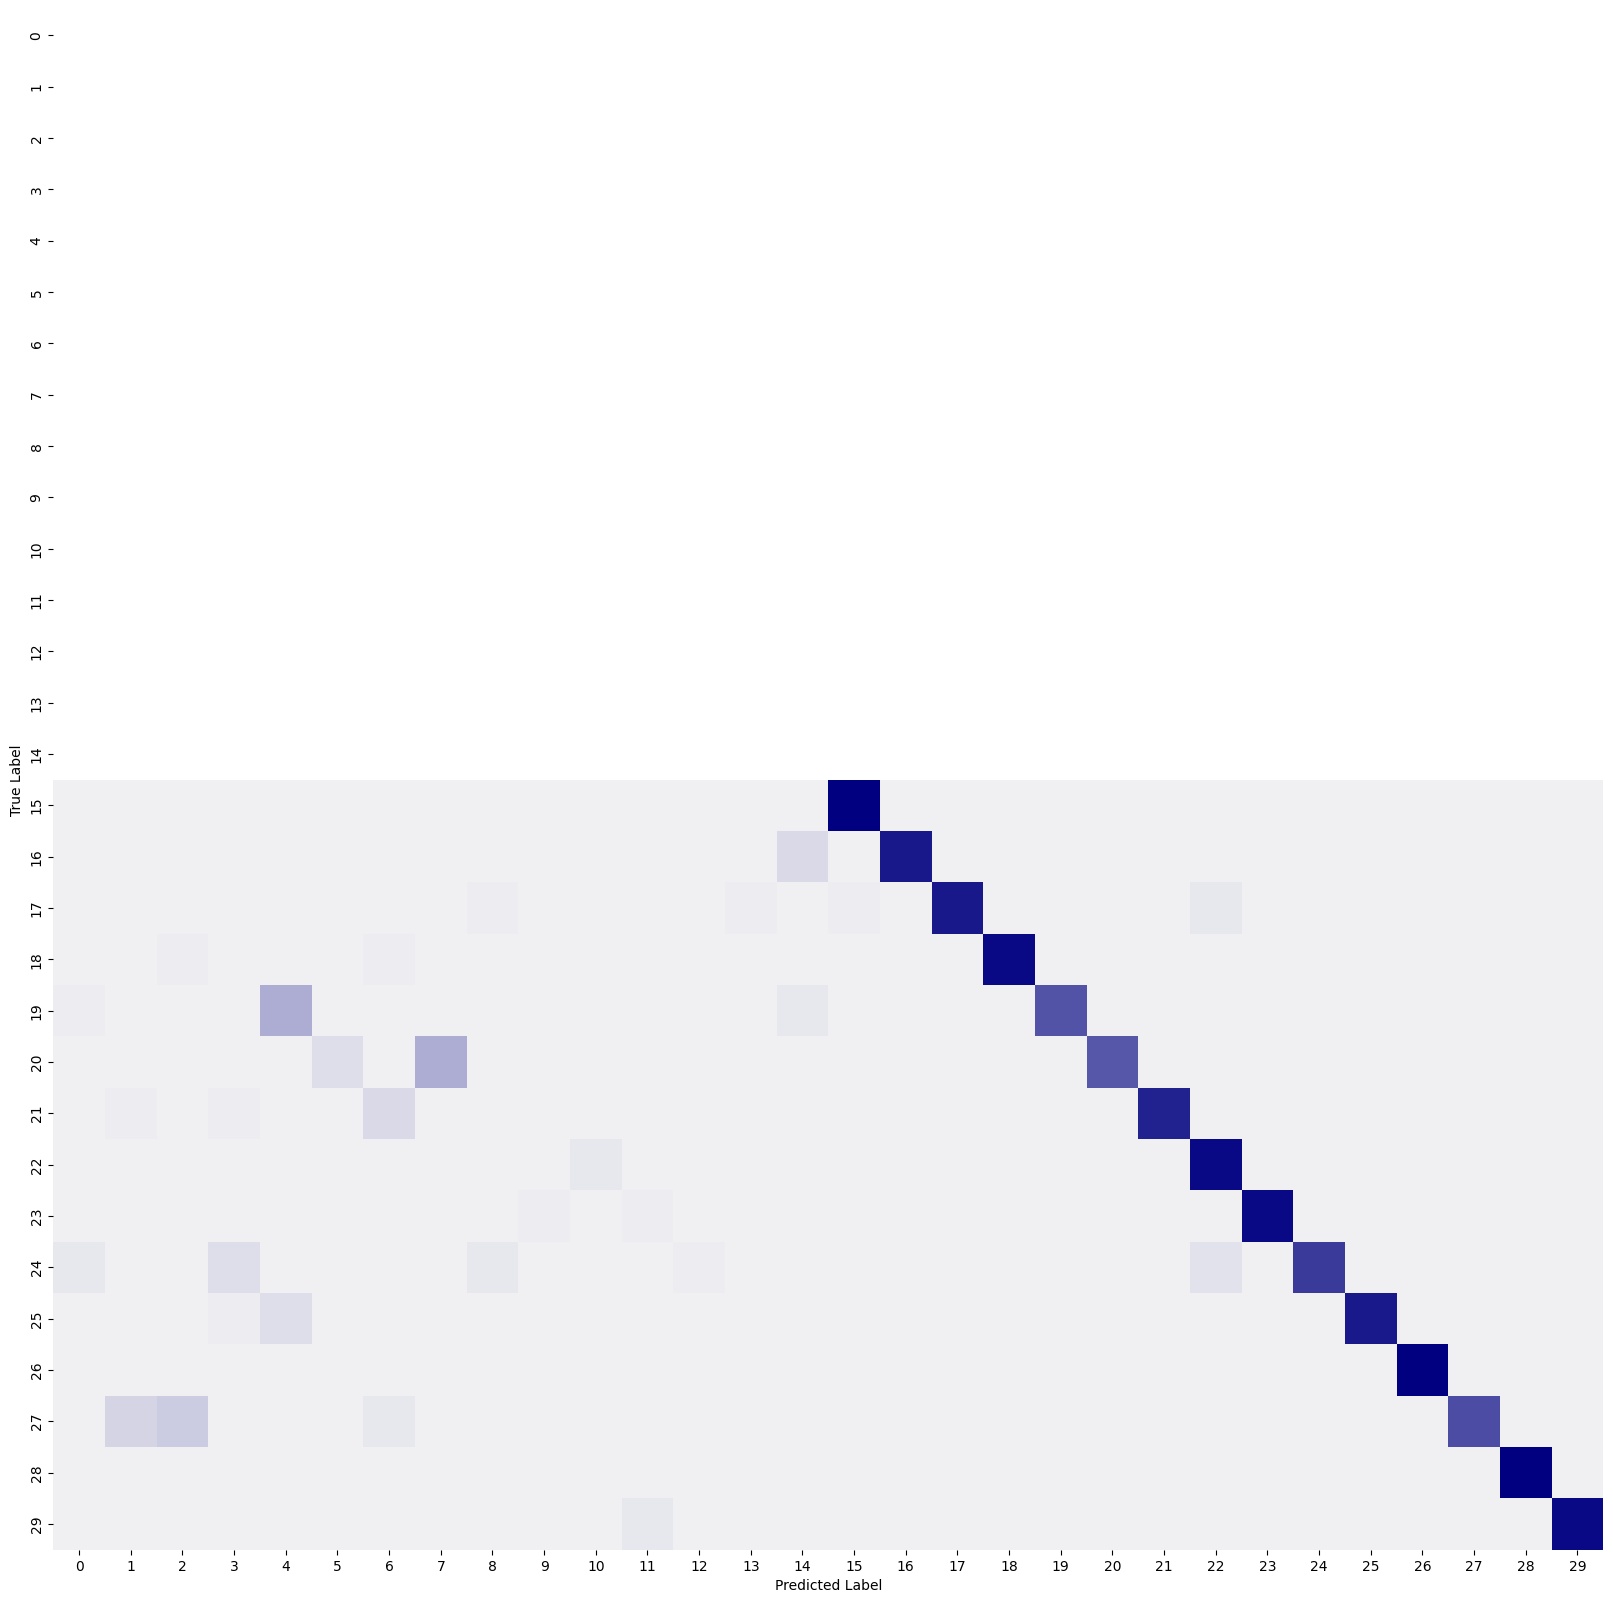

In [17]:
plot_conf(avg_label_test, pred_avg)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

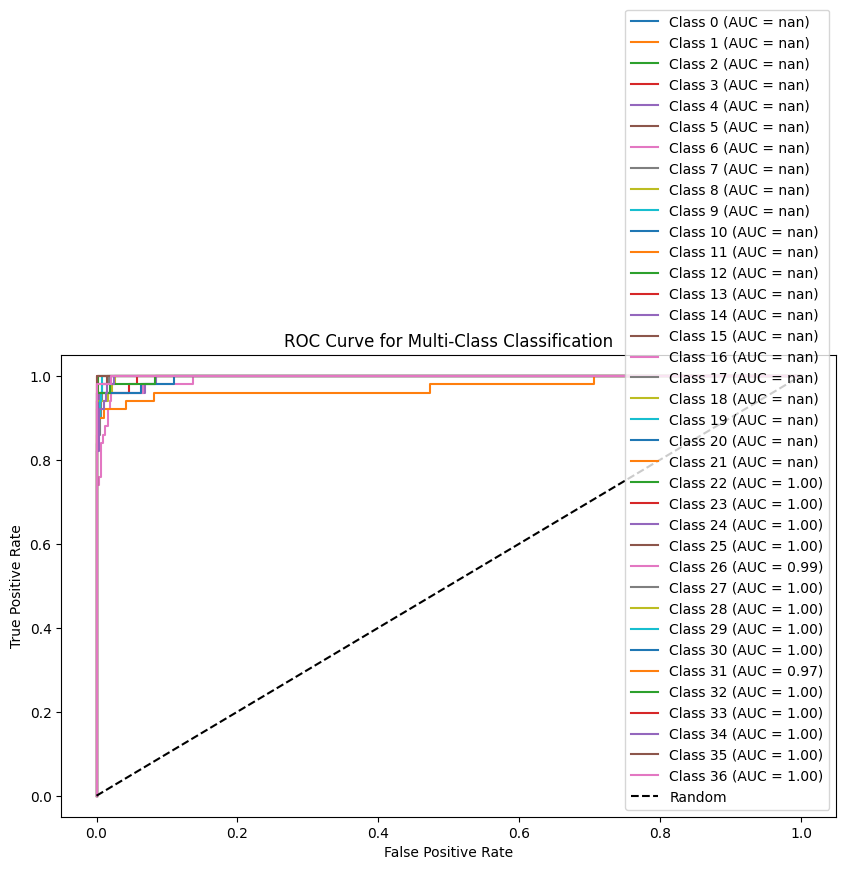

In [18]:
y_test_binarized = label_binarize(avg_label_test, classes=np.unique(avg_label_train))
plot_multiclass_roc_curve(avg_features_train, avg_label_train, avg_features_test, y_test_binarized, svm_model_avg)

In [19]:
pred_layer1, svm_model_layer1 = classify(new_block1_features_train, new_block1_features_test, block1_label_train, block1_label_test)

Accuracy: 2.3098


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_984\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

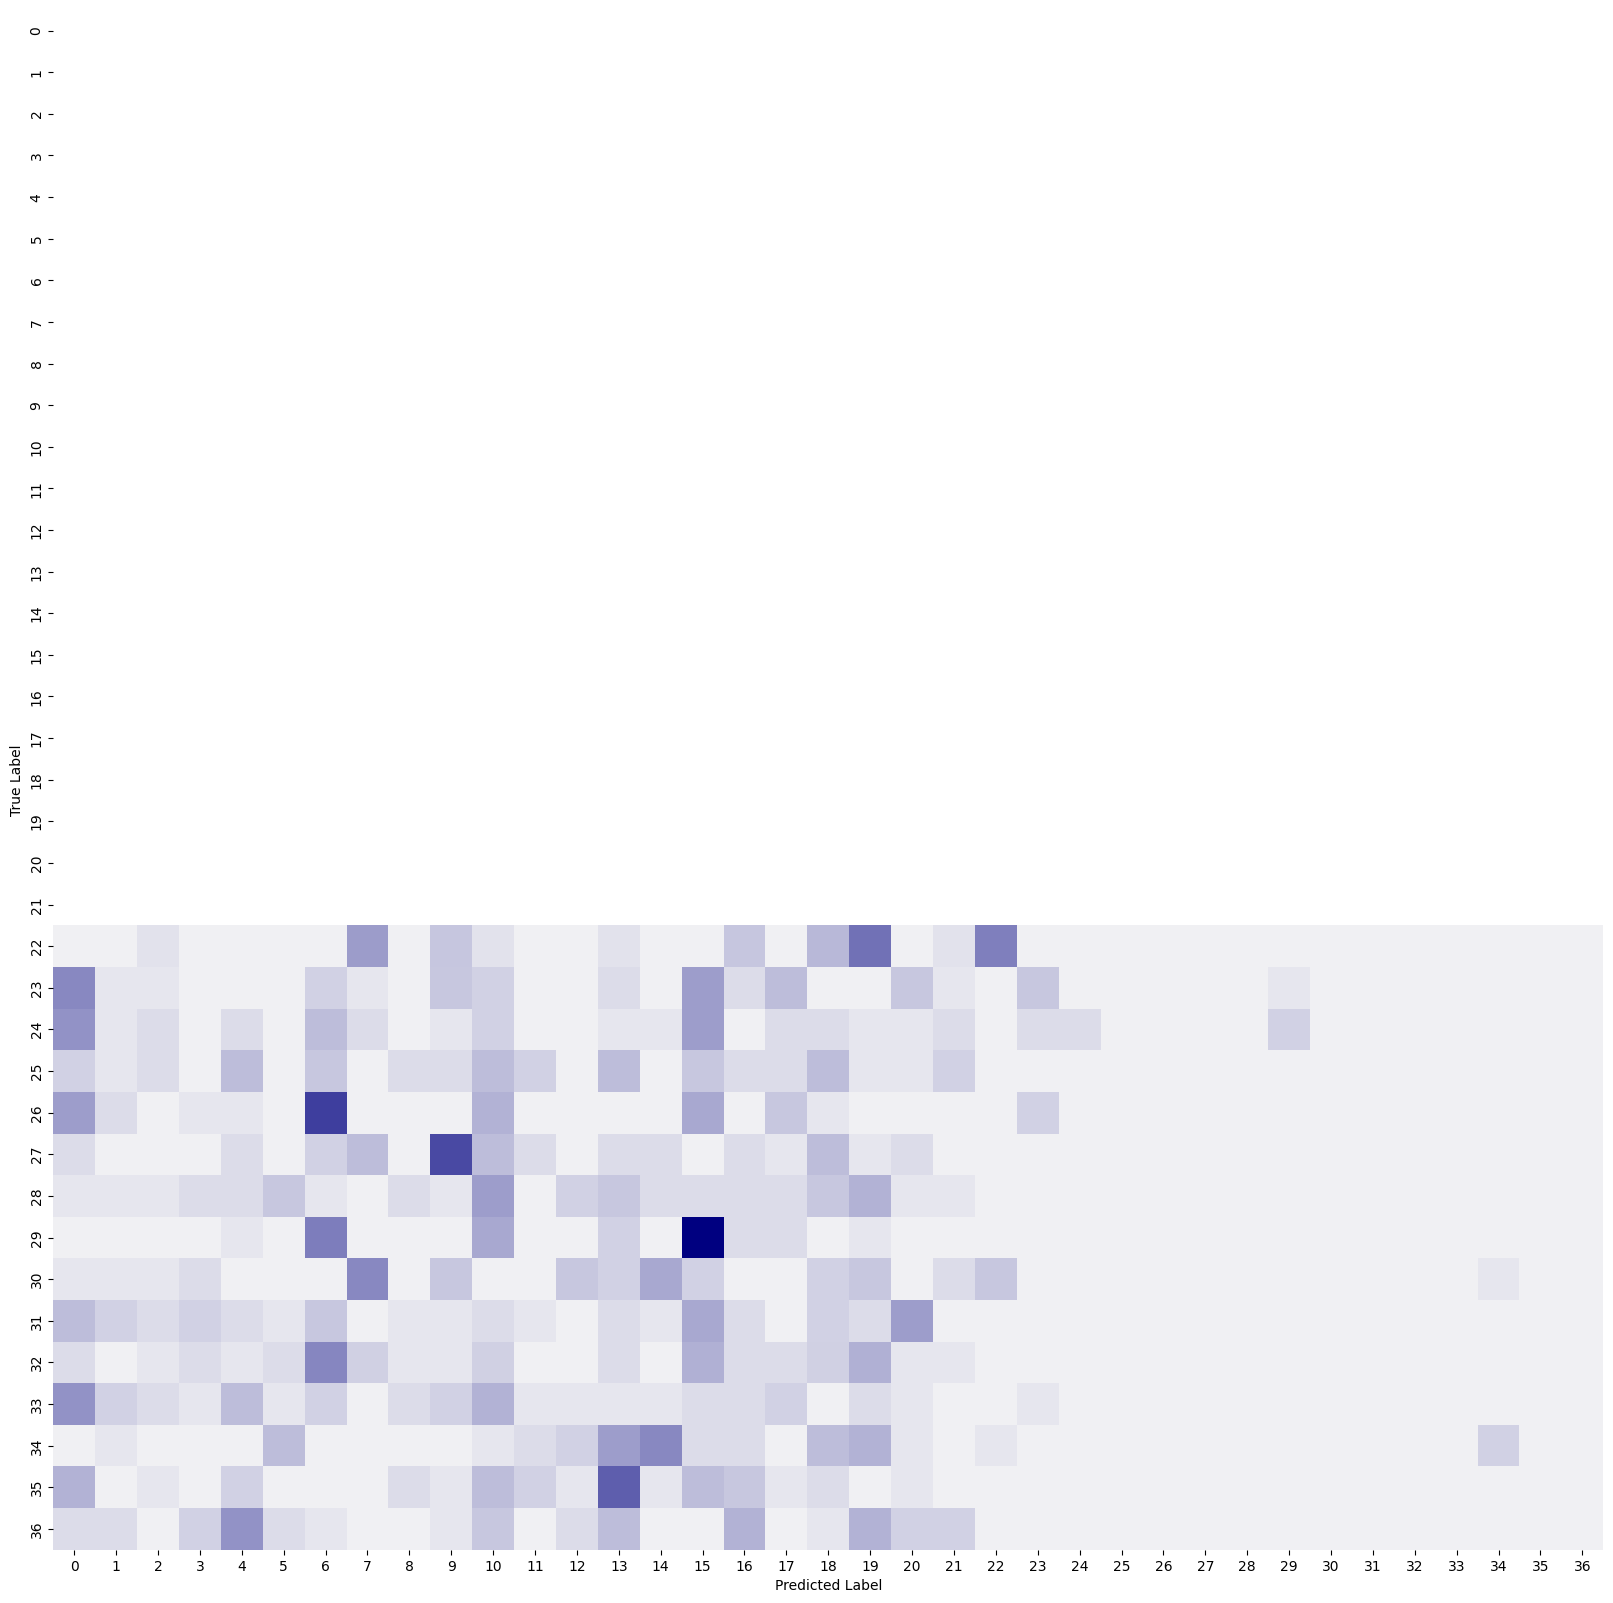

In [20]:
plot_conf(block1_label_test, pred_layer1)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

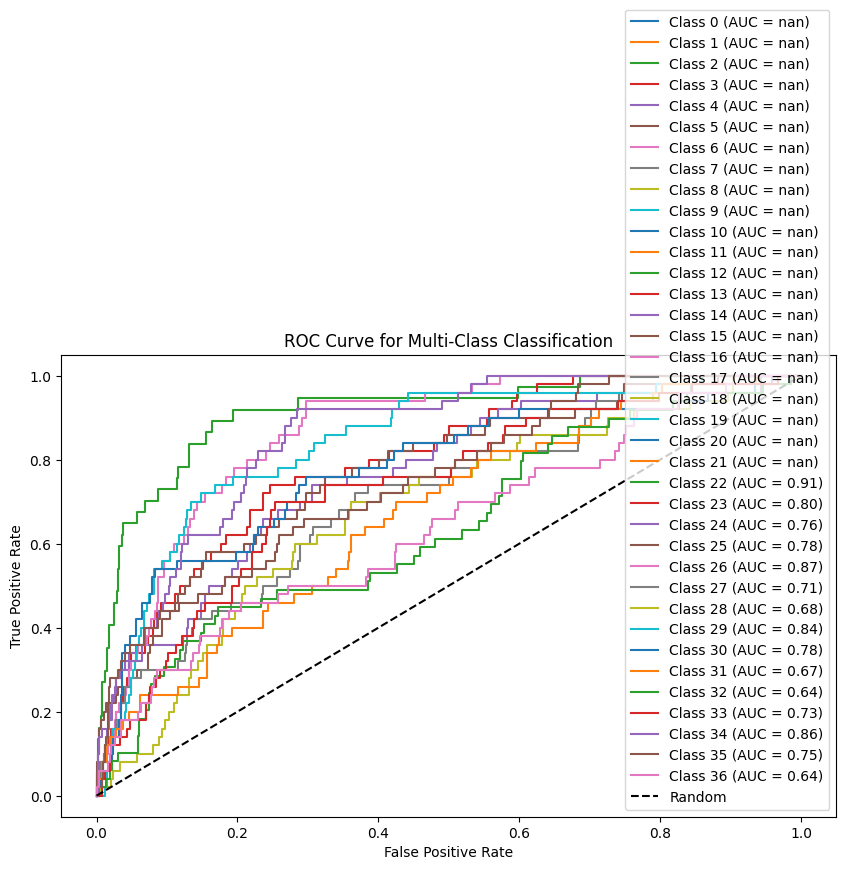

In [21]:
y_test_binarized2 = label_binarize(block1_label_test, classes=np.unique(block1_label_train))
plot_multiclass_roc_curve(new_block1_features_train, block1_label_train, new_block1_features_test, y_test_binarized2, svm_model_layer1)

In [22]:
pred_layer3, svm_model_layer3 = classify(new_block3_features_train, new_block3_features_test, block3_label_train, block3_label_test)

Accuracy: 6.5217


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_984\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

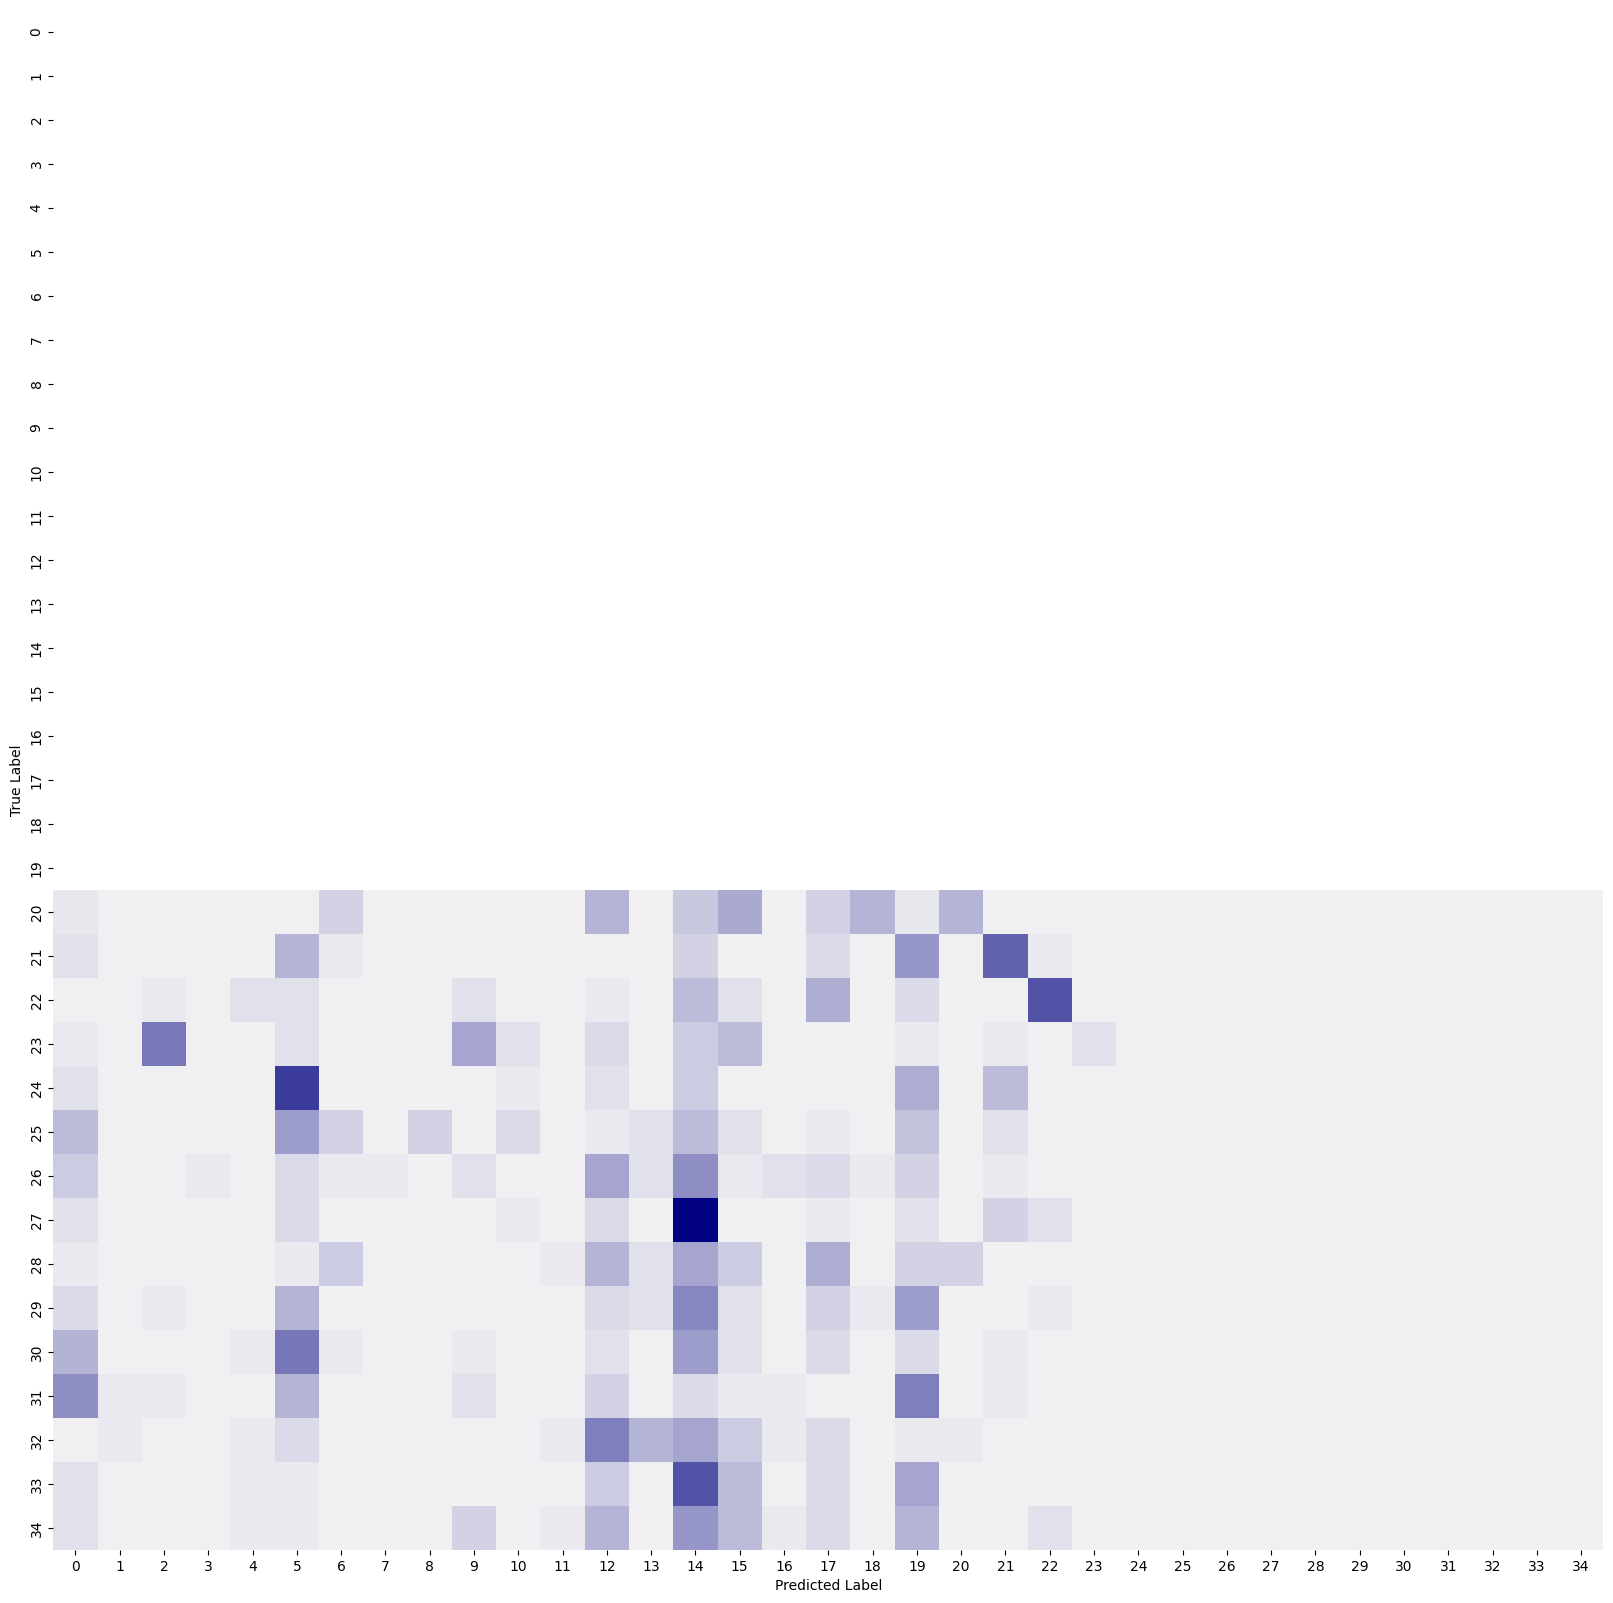

In [23]:
plot_conf(block3_label_test, pred_layer3)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

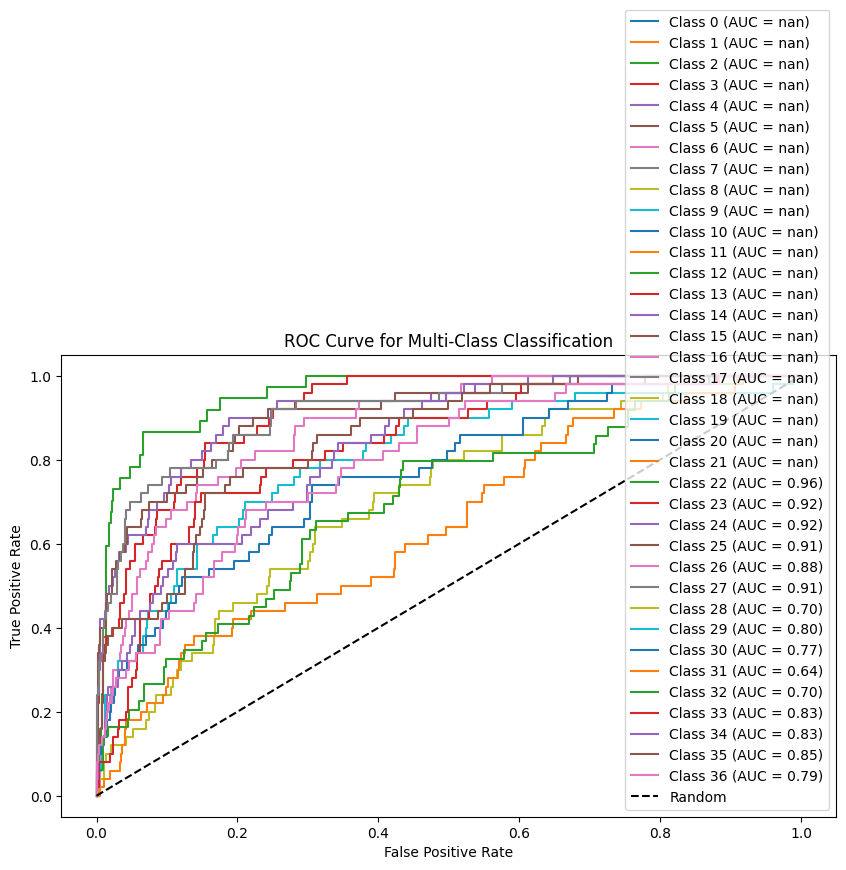

In [24]:
y_test_binarized3 = label_binarize(block3_label_test, classes=np.unique(block3_label_train))
plot_multiclass_roc_curve(new_block3_features_train, block3_label_train, new_block3_features_test, y_test_binarized3, svm_model_layer3)

## Result

```
First, load the resnet18 model.
Then, for feature extraction, create 3 classes, each extracting the corresponding layers, and then using the extract_features function, extract the relevant features and call the classify function for each of the 3 layers to train an SVM and evaluate the model's accuracy.
The descriptions of each of the functions are provided as comments.
As observed, the accuracy is very low in the first layer, because one reason is that the dimensions of the features are reduced using the PCA algorithm, and another reason is that this layer is one of the initial layers of the network, and specific features are not found up to that point.
In layer 3, the accuracy is higher than layer 1 because different conv layers have been passed through until that point, better features are extracted, and its accuracy is higher than layer 1, but the accuracy has decreased because PCA is used.
Finally, the accuracy of the avgPool layer is observed, which because it is part of the final layers, it has extracted good features and its accuracy is high.
The confusion matrix and ROC are plotted for each of them, as observed, it is good for the avgPool layer.

## GoogleNet

The key innovation in GoogLeNet is the inception module, which forms the building block of the architecture. An inception module consists of multiple convolutional layers with different kernel sizes, which are concatenated to capture features of different scales simultaneously. This parallelism helps GoogLeNet capture fine-grained details as well as high-level features, making it exceptionally effective at image recognition tasks.

Each inception module reduces the computational cost by utilizing 1x1 convolutions to perform dimensionality reduction before applying larger convolutional kernels. This not only saves computation but also acts as a regularizer, preventing overfitting.

The GoogLeNet architecture includes multiple such inception modules stacked together, leading to a network with impressive depth and accuracy. Moreover, the researchers introduced auxiliary classifiers at intermediate layers, which helped in addressing the vanishing gradient problem during training.

<img src="https://i.postimg.cc/nLK4GthP/google-Net.webp">

An Inception module computes multiple different transformations over the same input map in parallel, concatenating their results into a single output. In other words, for each layer, Inception does a 5x5 convolutional transformation, and a 3x3, and a max-pool. And the next layer of the model gets to decide if (and how) to use each piece of information.

<img src="https://i.postimg.cc/SRPCxSgJ/gnLayer.webp" alt="gnLayer">

The increased information density of this model architecture comes with one glaring problem: we’ve drastically increased computational costs. Not only are large (e.g. 5x5) convolutional filters inherently expensive to compute, stacking multiple different filters side by side greatly increases the number of feature maps per layer. And this increase becomes a deadly bottleneck in our model.

Think about it this way. For each additional filter added, we have to convolve over all the input maps to calculate a single output. See the image below: creating one output map from a single filter involves computing over every single map from the previous layer.

<img src="https://i.postimg.cc/k4XbN6Z2/gnKernel.webp">



In [11]:
class GoogleNet3BFeatureExtractor(nn.Module):
    """
    Feature extractor using GoogleNet architecture with extraction up to block 3B.

    Args:
    - model: Pre-trained GoogleNet model

    Returns:
    - Features extracted from the model up to block 3B
    """

    def __init__(self, model):
        super(GoogleNet3BFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:7]
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


class GoogleNet4EFeatureExtractor(nn.Module):
    """
    Feature extractor using GoogleNet architecture with extraction up to block 4E.

    Args:
    - model: Pre-trained GoogleNet model

    Returns:
    - Features extracted from the model up to block 4E
    """

    def __init__(self, model):
        super(GoogleNet4EFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-7]
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


class GoogleNetAvgpoolFeatureExtractor(nn.Module):
    """
    Feature extractor using GoogleNet architecture with adaptive average pooling.

    Args:
    - model: Pre-trained GoogleNet model

    Returns:
    - Features extracted from the model with adaptive average pooling
    """

    def __init__(self, model):
        super(GoogleNetAvgpoolFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.children())[:-2],
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


In [12]:
googleNet_3B_extractor = GoogleNet3BFeatureExtractor(googlenet)
googleNet_4E_extractor = GoogleNet4EFeatureExtractor(googlenet)
googleNet_avgpool_extractor = GoogleNetAvgpoolFeatureExtractor(googlenet)

### B3 Layer

In [18]:
b3_features_train, b3_label_train = extract_features(googleNet_3B_extractor, train_loader)
b3_features_test, b3_label_test = extract_features(googleNet_3B_extractor, test_loader)

In [14]:
new_b3_features_train, new_b3_features_test = pca(b3_features_train, b3_features_test)

In [15]:
pred_b3, svm_model_b3 = classify(new_b3_features_train, new_b3_features_test, b3_label_train, b3_label_test)

Accuracy: 7.2011


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7984\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

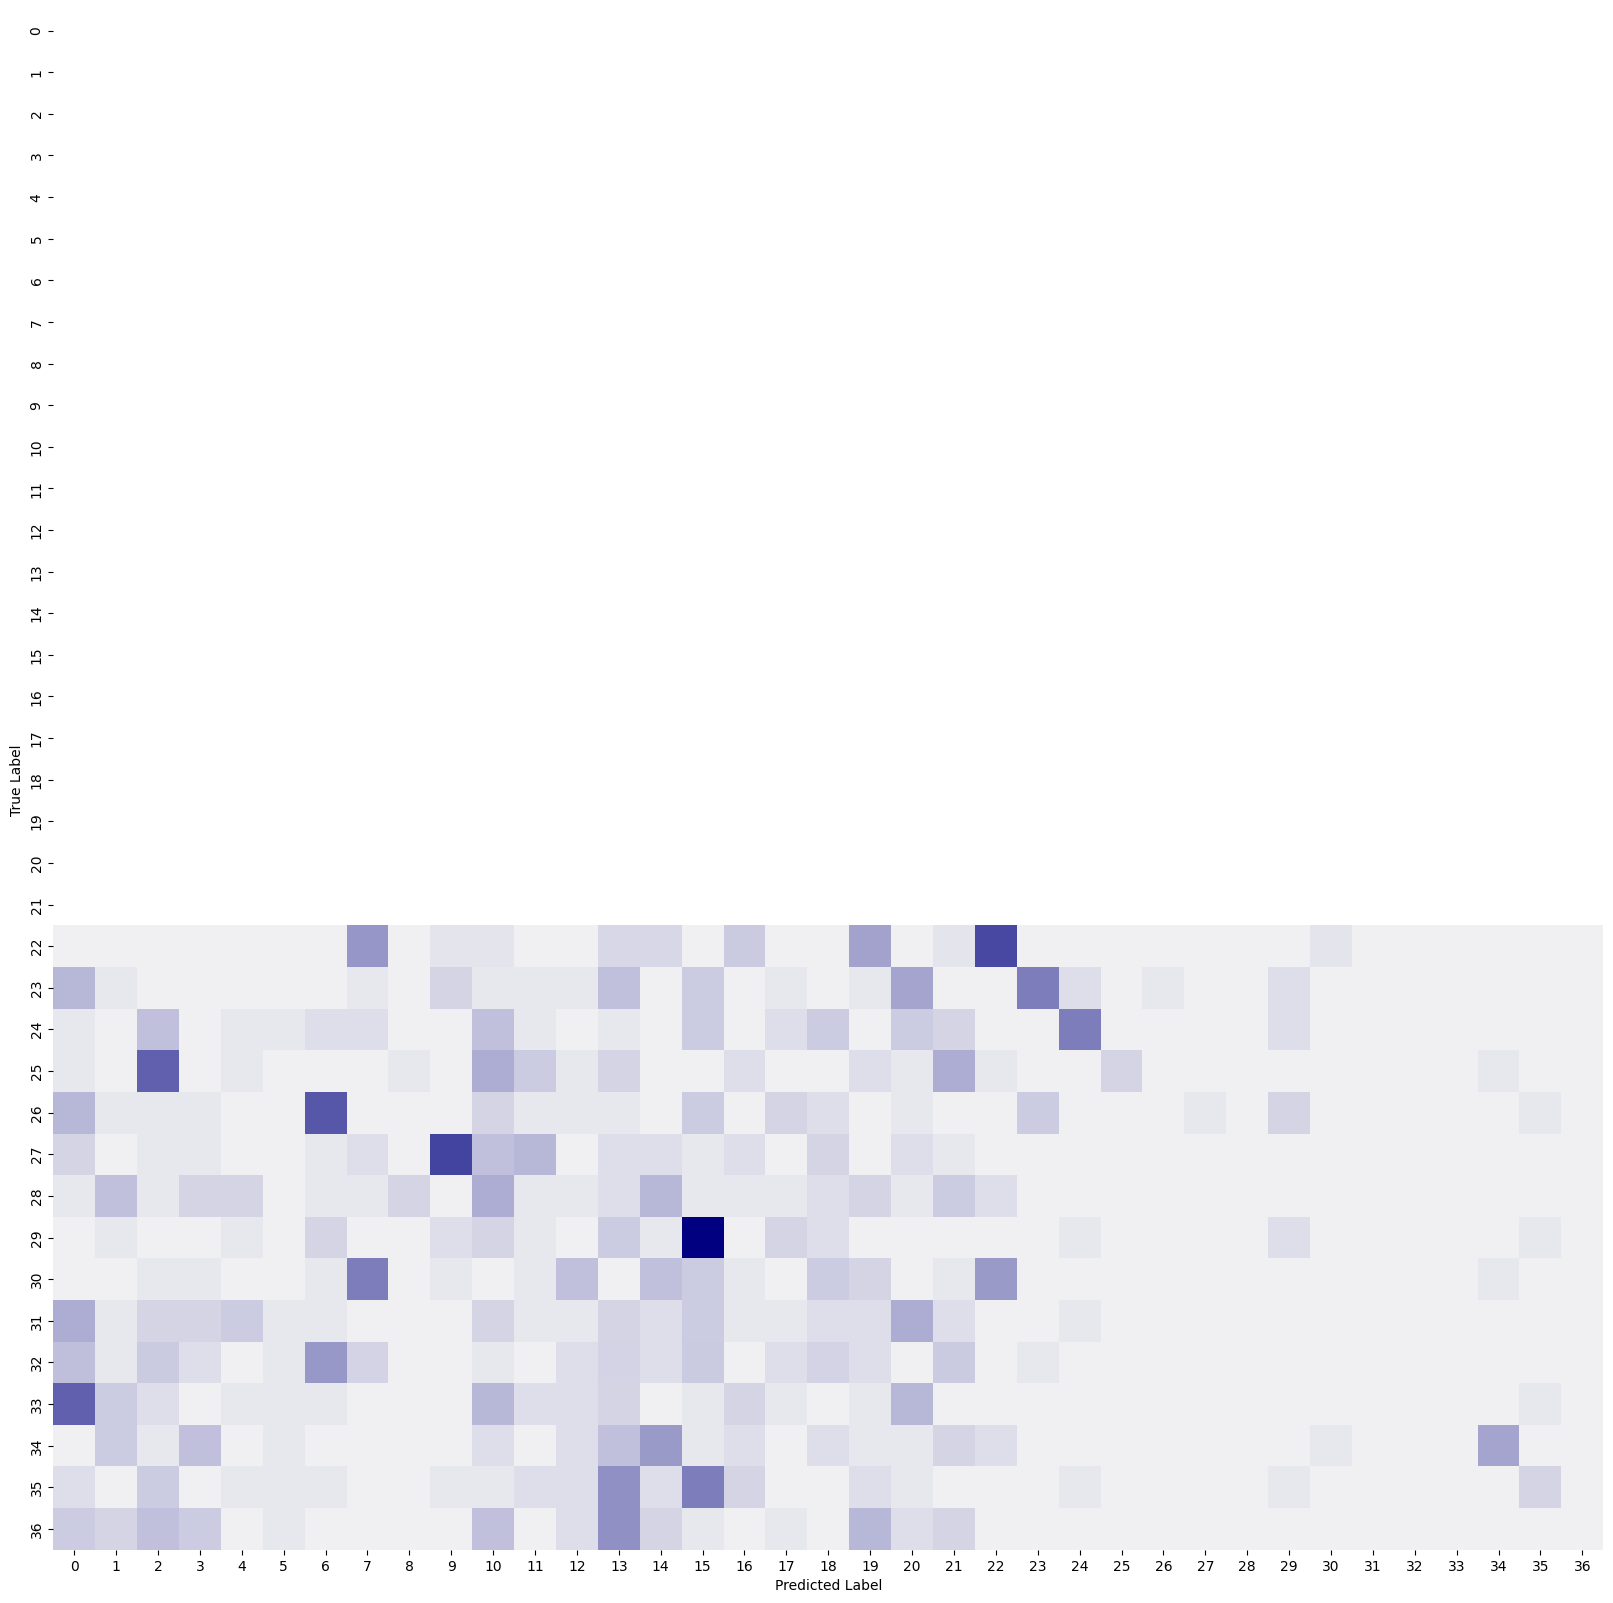

In [19]:
plot_conf(b3_label_test, pred_b3)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

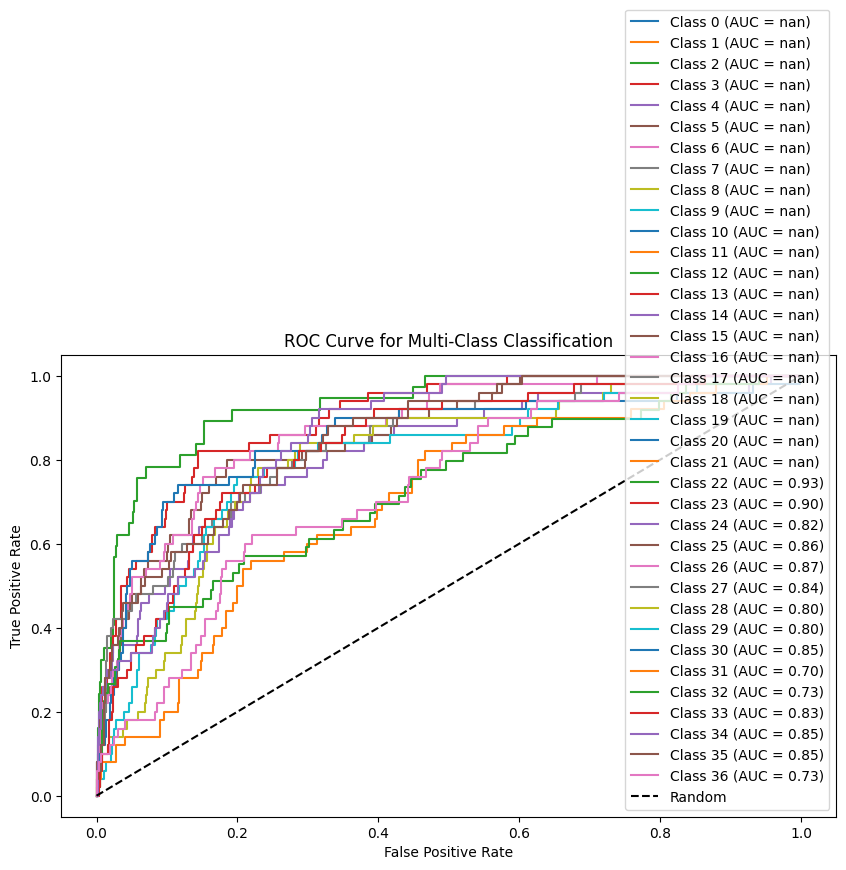

In [20]:
y_test_binarized4 = label_binarize(b3_label_test, classes=np.unique(b3_label_train))
plot_multiclass_roc_curve(new_b3_features_train, b3_label_train, new_b3_features_test, y_test_binarized4, svm_model_b3)

### E4 layer

In [16]:
e4_features_train, e4_label_train = extract_features(googleNet_4E_extractor, train_loader)
e4_features_test, e4_label_test = extract_features(googleNet_4E_extractor, test_loader)

In [17]:
new_e4_features_train, new_e4_features_test = pca(e4_features_train, e4_features_test)

In [18]:
pred_e4, svm_model_e4 = classify(new_e4_features_train, new_e4_features_test, e4_label_train, e4_label_test)

Accuracy: 15.0815


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7984\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

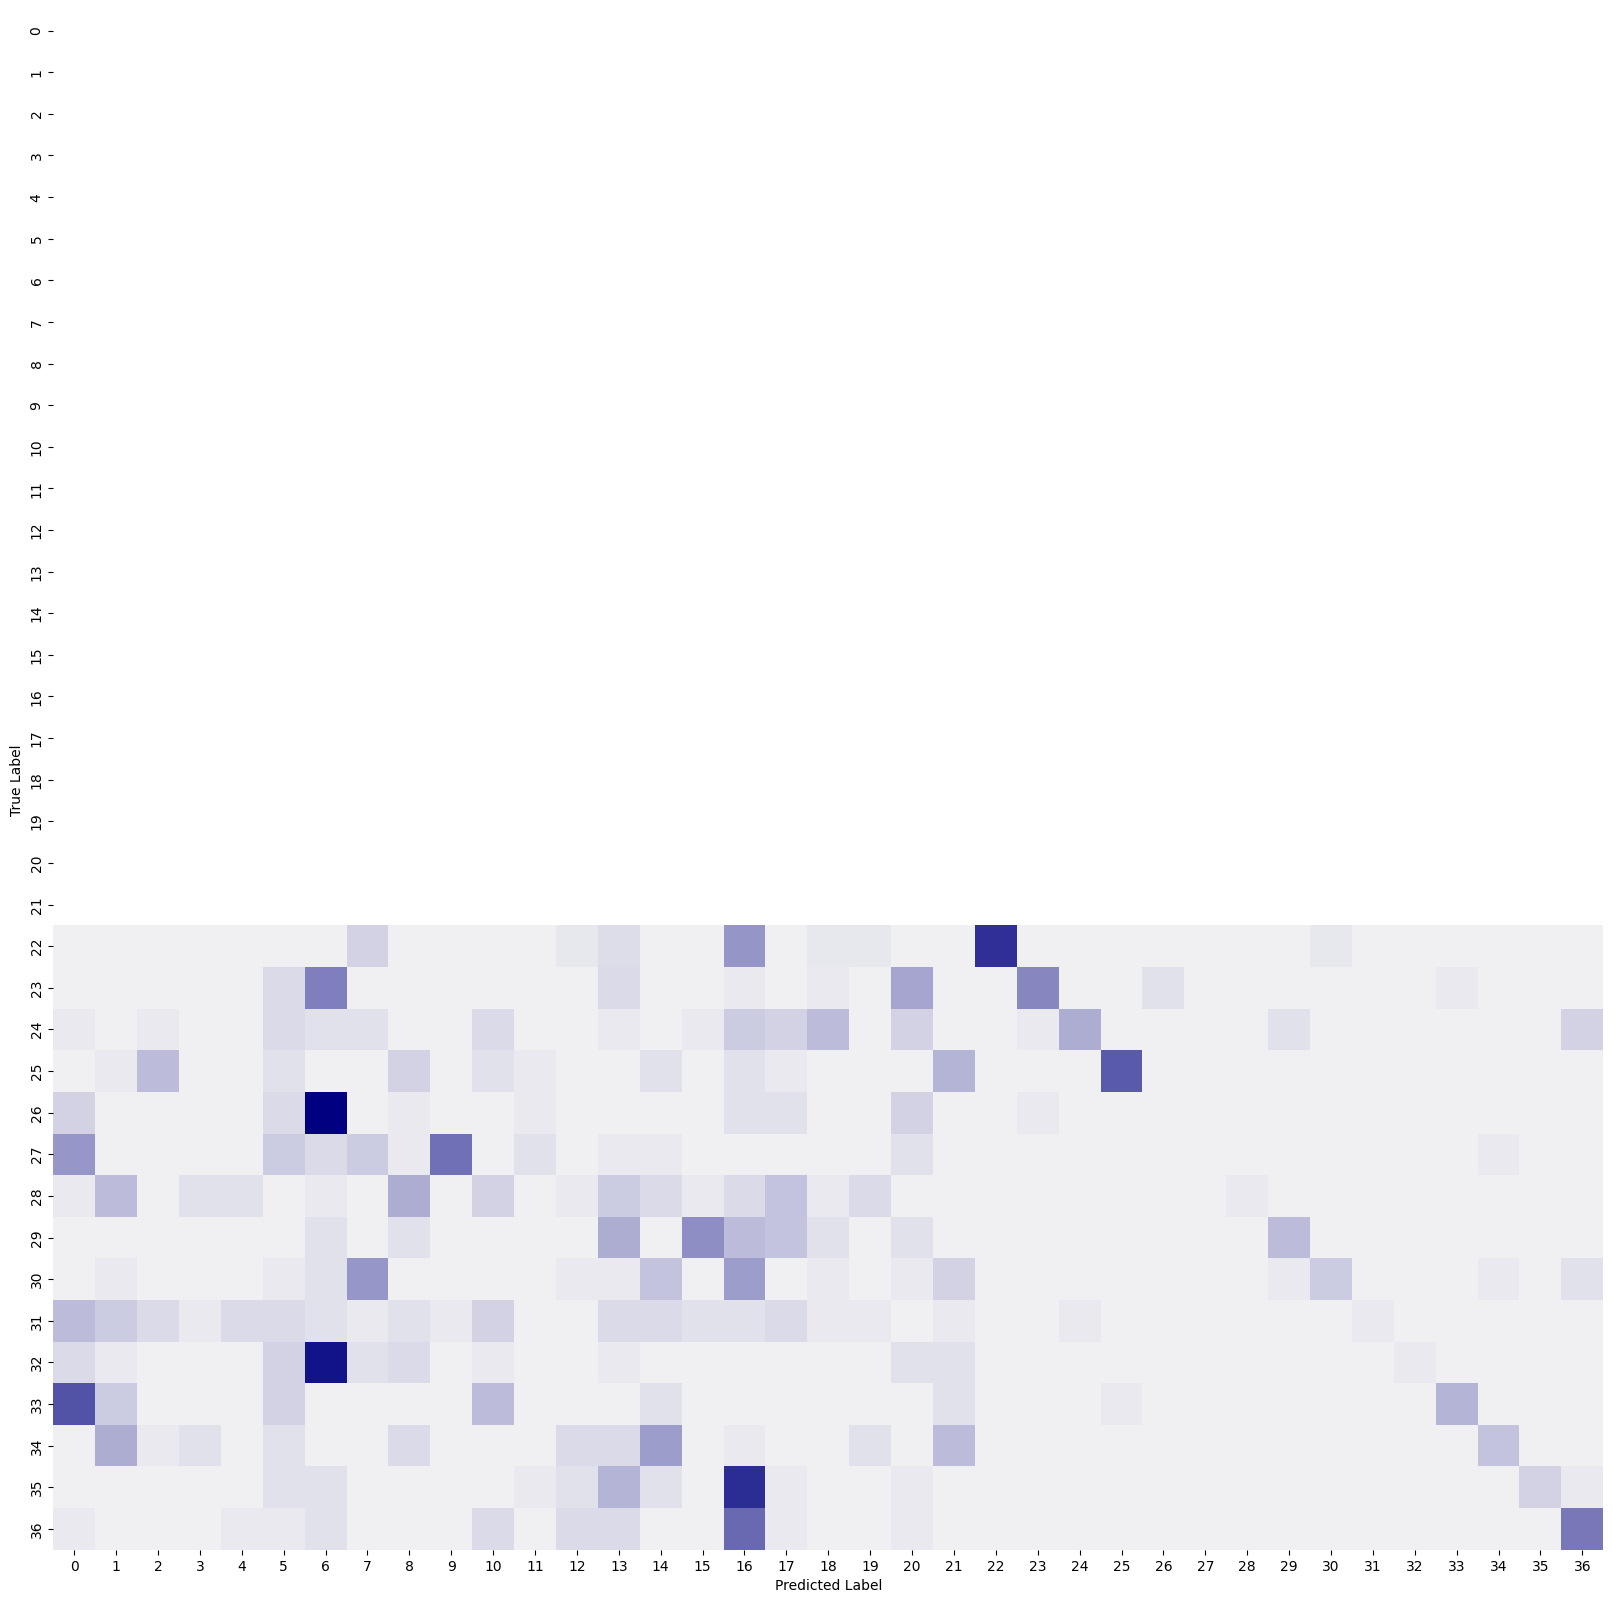

In [21]:
plot_conf(e4_label_test, pred_e4)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

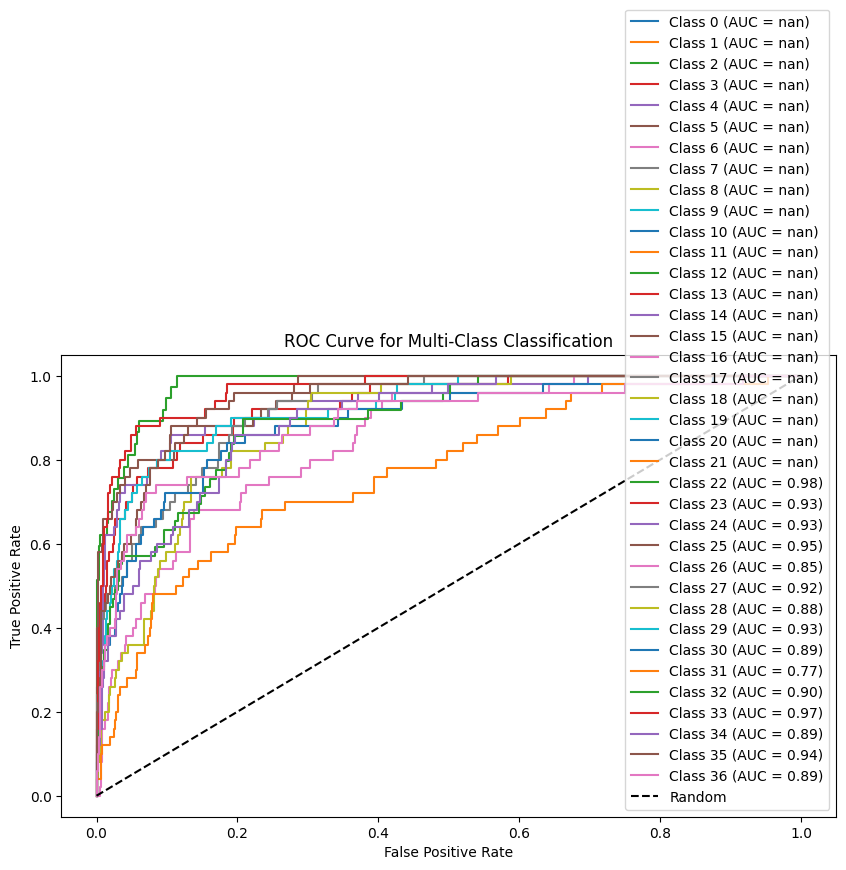

In [22]:
y_test_binarized5 = label_binarize(e4_label_test, classes=np.unique(e4_label_train))
plot_multiclass_roc_curve(new_e4_features_train, e4_label_train, new_e4_features_test, y_test_binarized5, svm_model_e4)

### AvgPool Layer

In [13]:
gn_avg_features_train, gn_avg_label_train = extract_features(googleNet_avgpool_extractor, train_loader)
gn_avg_features_test, gn_avg_label_test = extract_features(googleNet_avgpool_extractor, test_loader)

In [25]:
pred_gn_avg, svm_model_gn_avg = classify(gn_avg_features_train, gn_avg_features_test, gn_avg_label_train, gn_avg_label_test)

Accuracy: 82.8804


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7984\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

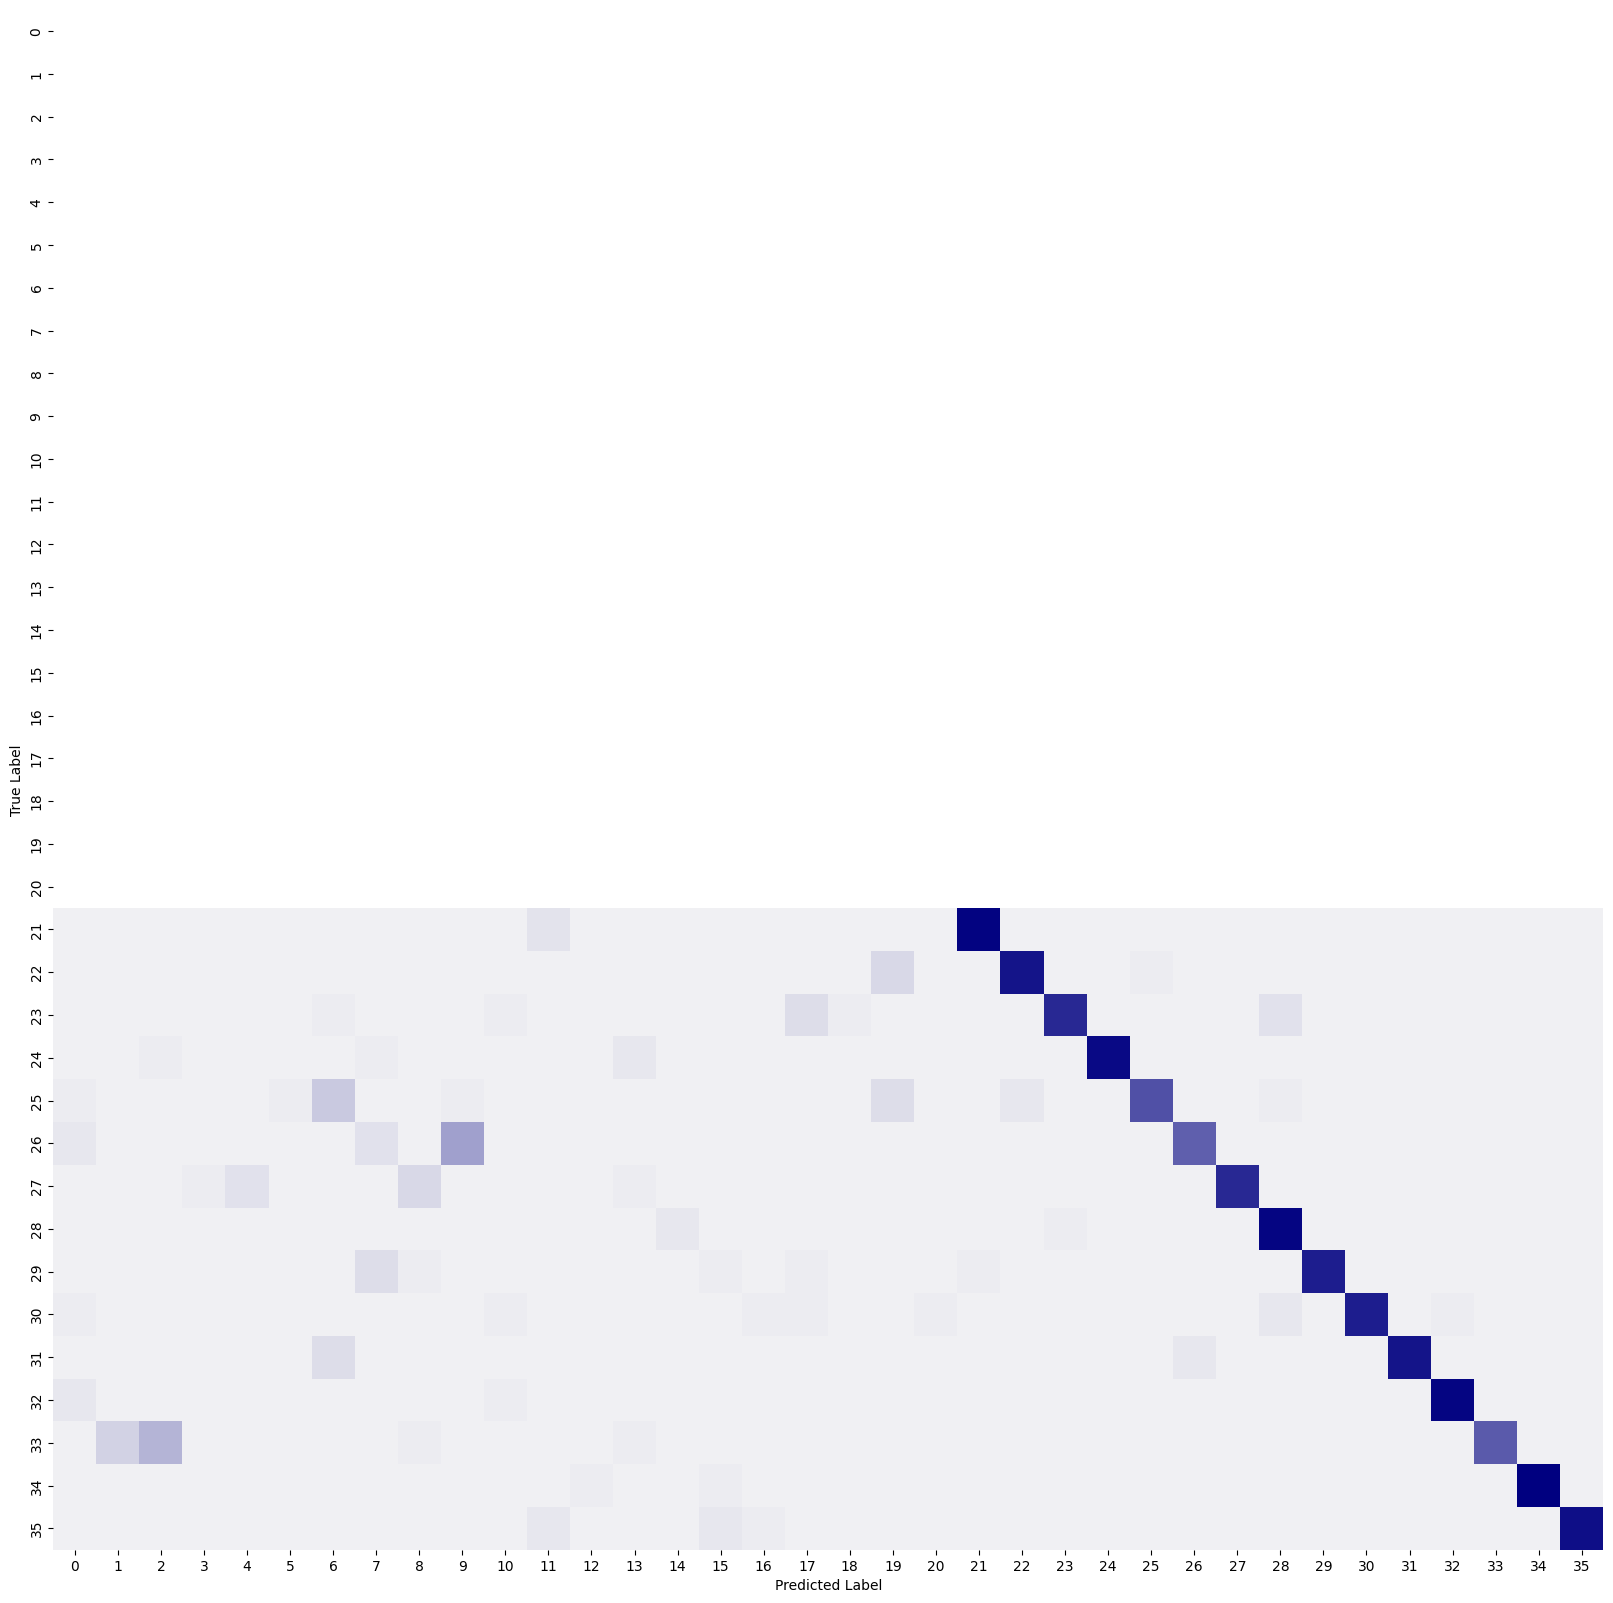

In [26]:
plot_conf(gn_avg_label_test, pred_gn_avg)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

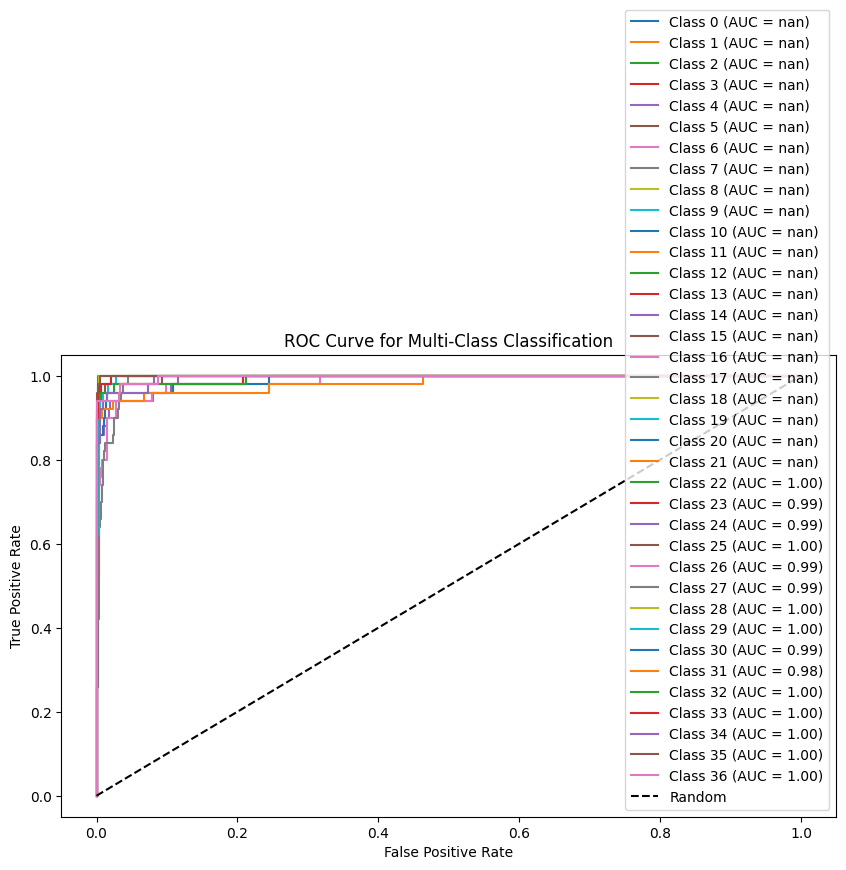

In [27]:
y_test_binarized6 = label_binarize(gn_avg_label_test, classes=np.unique(gn_avg_label_train))
plot_multiclass_roc_curve(gn_avg_features_train, gn_avg_label_train, gn_avg_features_test, y_test_binarized6, svm_model_gn_avg)

## Result

```
For the MobileNet model, first extract the necessary layers and then extract the required features using the extract_features function.
Because the b3 layer is located early in the network, the classification accuracy with SVM on it is lower, and also because the dimensions of the feature vectors are reduced with the PCA algorithm, the output accuracy has decreased significantly from the normal state.
For the e4 layer, this layer is located in a more intermediate part of the network and has extracted better features, so the accuracy is higher, but again, because its dimensions are reduced with PCA, its accuracy has still decreased, but the accuracy in these two layers is better than the ResNet model.
In the avgPool layer, because it is a more final layer, practically the final features are extracted, which their weights are completely trained, and for this reason, they are better features, and the classification accuracy on them is higher.
Confusion matrix and ROC curve are also plotted for them.


## MobileNet

A lightweight convolutional neural network (CNN) architecture, MobileNetV2, is specifically designed for mobile and embedded vision applications. Google researchers developed it as an enhancement over the original MobileNet model. Another remarkable aspect of this model is its ability to strike a good balance between model size and accuracy, rendering it ideal for resource-constrained devices.

The MobileNetV2 architecture is based on an inverted residual structure where the input and output of the residual block are thin bottleneck layers opposite to traditional residual models which use expanded representations in the input an MobileNetV2 uses lightweight depthwise convolutions to filter features in the intermediate expansion layer. Additionally, we find that it is important to remove non-linearities in the narrow layers in order to maintain representational power. We demonstrate that this improves performance and provide an intuition that led to this design. Finally, our approach allows decoupling of the input/output domains from the expressiveness of the transformation, which provides a convenient framework for further analysis. We measure our performance on Imagenet classification, COCO object detection, VOC image segmentation. We evaluate the trade-offs between accuracy, and number of operations measured by multiply-adds (MAdd), as well as the number of parameters

<img src="https://i.postimg.cc/c1RptKWR/mobile-Net2.png" alt="mobileNet">



<ul>
    <li>Inverted Residuals</br>
        &emsp;Inverted residuals are a key component of MobileNetV2 that helps improve the model’s accuracy. They introduce a bottleneck structure that</br>
        &emsp;expands the number of channels before applying depthwise separable convolutions. This expansion allows the model to capture more complex </br>
        &emsp;features and enhance its representation power.
    </li></br>
    <li>Bottleneck Design</br>
        &emsp;The bottleneck design in MobileNetV2 further reduces the computational cost by using 1×1 convolutions to reduce the number of channels before</br> &emsp;applying depthwise separable convolutions. This design choice helps maintain a good balance between model size and accuracy.
    </li></br>
    <li>Linear Bottlenecks</br>
        &emsp;Linear bottlenecks are introduced in MobileNetV2 to address the issue of information loss during the bottleneck process. By using linear</br>
        &emsp;activations instead of non-linear activations, the model preserves more information and improves its ability to capture fine-grained details.
    </li></br>
    <li>Squeeze-and-Excitation (SE) Blocks</br>
        &emsp;Squeeze-and-excitation (SE) blocks are added to MobileNetV2 to enhance its feature representation capabilities. These blocks adaptively</br>
        &emsp;recalibrate the channel-wise feature responses, allowing the model to focus on more informative features and suppress less relevant ones.
    </li>
</ul>

In [14]:
class MobileNetFirstConvFeatureExtractor(nn.Module):
    """
    Feature extractor using MobileNet architecture with extraction from the first convolutional layer.

    Args:
    - model: Pre-trained MobileNet model

    Returns:
    - Features extracted from the model starting from the first convolutional layer
    """

    def __init__(self, model):
        super(MobileNetFirstConvFeatureExtractor, self).__init__()
        self.features = model.features[:2]

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


class MobileNetMiddleLayerFeatureExtractor(nn.Module):
    """
    Feature extractor using MobileNet architecture with extraction from the middle layer.

    Args:
    - model: Pre-trained MobileNet model

    Returns:
    - Features extracted from the model from the first layer to the middle layer
    """

    def __init__(self, model):
        super(MobileNetMiddleLayerFeatureExtractor, self).__init__()
        self.features = model.features[:4]

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)


class MobileNetAvgpoolFeatureExtractor(nn.Module):
    """
    Feature extractor using MobileNet architecture with adaptive average pooling.

    Args:
    - model: Pre-trained MobileNet model

    Returns:
    - Features extracted from the model with adaptive average pooling
    """

    def __init__(self, model):
        super(MobileNetAvgpoolFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            *list(model.features.children())[:-1],
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

In [15]:
mobilenet_first_conv_extractor = MobileNetFirstConvFeatureExtractor(mobilenet_v2)
mobilenet_middle_layer_extractor = MobileNetMiddleLayerFeatureExtractor(mobilenet_v2)
mobilenet_avgpool_extractor = MobileNetAvgpoolFeatureExtractor(mobilenet_v2)

### AvgPool Layer

In [16]:
mn_avg_features_train, mn_avg_label_train = extract_features(mobilenet_avgpool_extractor, train_loader)
mn_avg_features_test, mn_avg_label_test = extract_features(mobilenet_avgpool_extractor, test_loader)

In [21]:
pred_mn_avg, svm_model_mn_avg = classify(mn_avg_features_train, mn_avg_features_test, mn_avg_label_train, mn_avg_label_test)

Accuracy: 85.0543


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4176\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

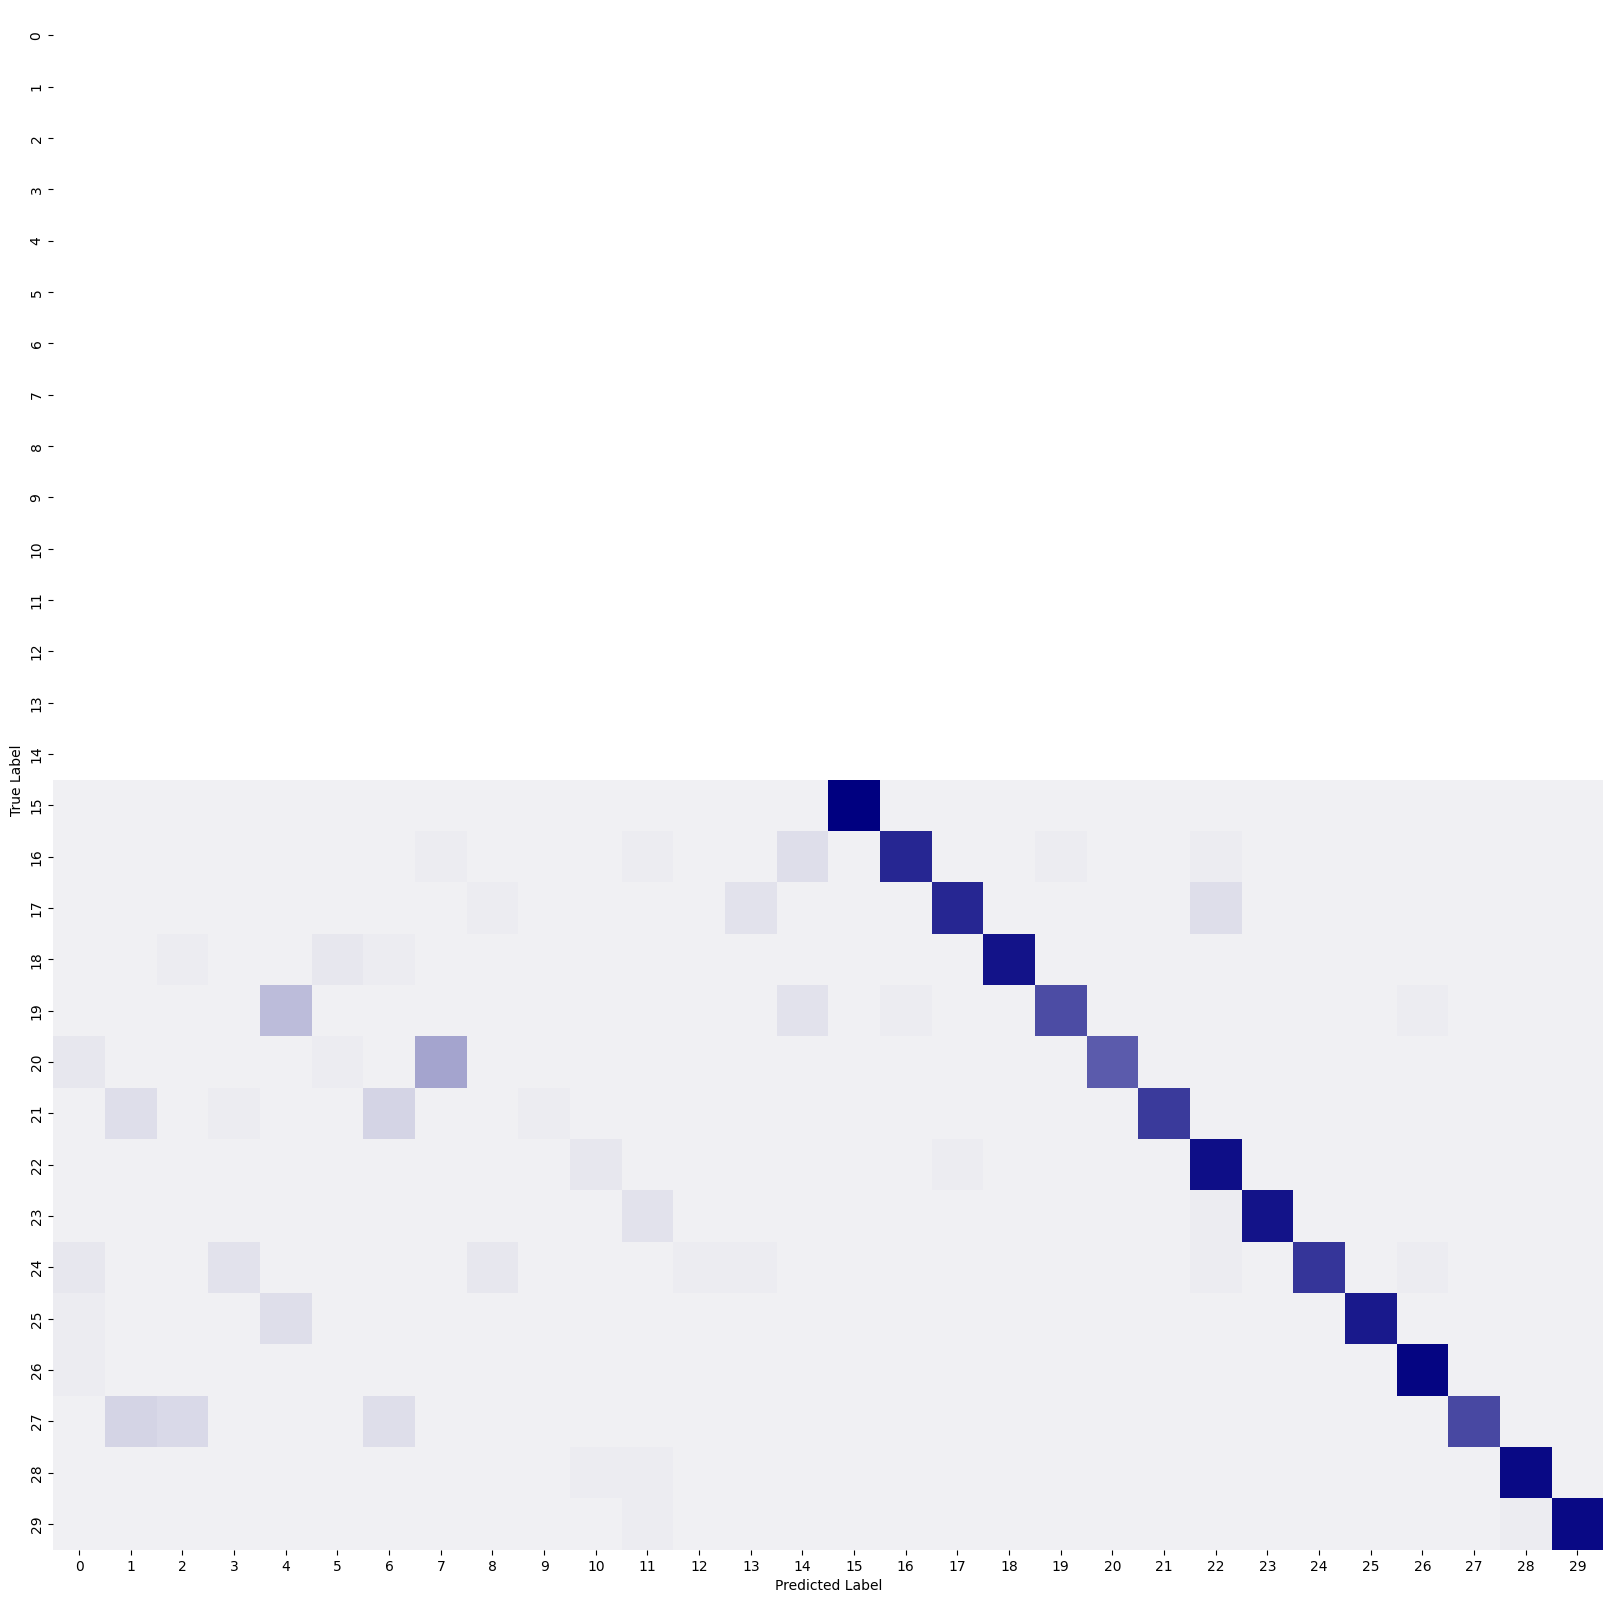

In [26]:
plot_conf(mn_avg_label_test, pred_mn_avg)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

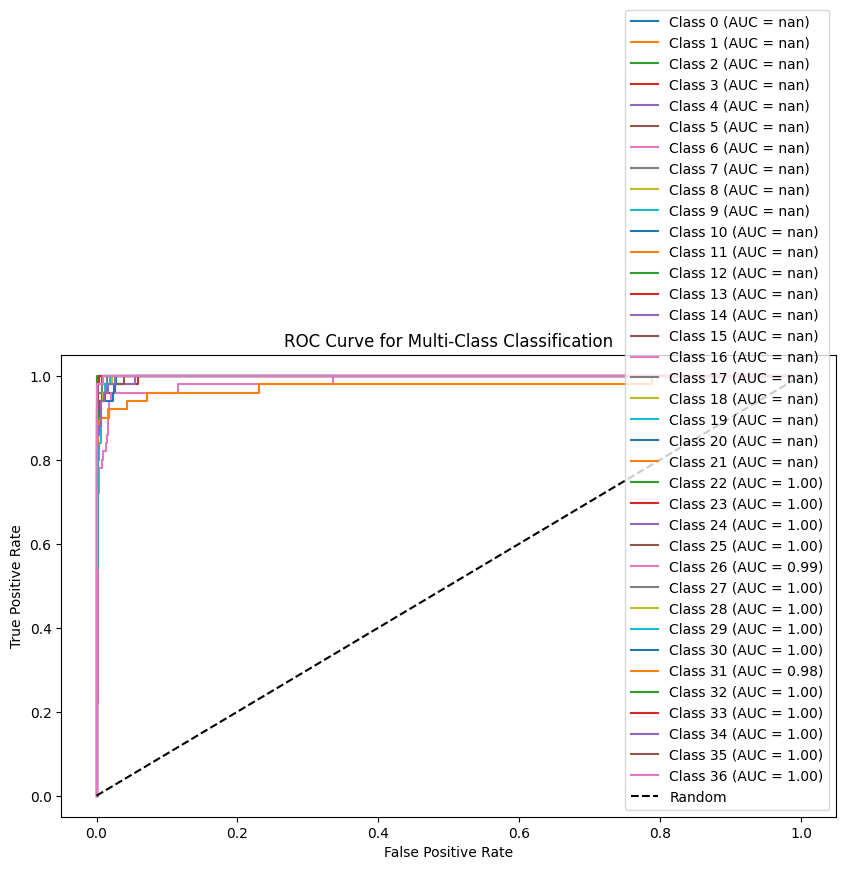

In [28]:
y_test_binarized7 = label_binarize(mn_avg_label_test, classes=np.unique(mn_avg_label_train))
plot_multiclass_roc_curve(mn_avg_features_train, mn_avg_label_train, mn_avg_features_test, y_test_binarized7, svm_model_mn_avg)

### Middle Layer

In [23]:
middle_features_train, middle_label_train = extract_features(mobilenet_middle_layer_extractor, train_loader)
middle_features_test, middle_label_test = extract_features(mobilenet_middle_layer_extractor, test_loader)

In [24]:
new_middle_features_train, new_middle_features_test = pca(middle_features_train, middle_features_test)

In [25]:
pred_middle, svm_model_middle = classify(new_middle_features_train, new_middle_features_test, middle_label_train, middle_label_test)

Accuracy: 2.8533


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10440\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

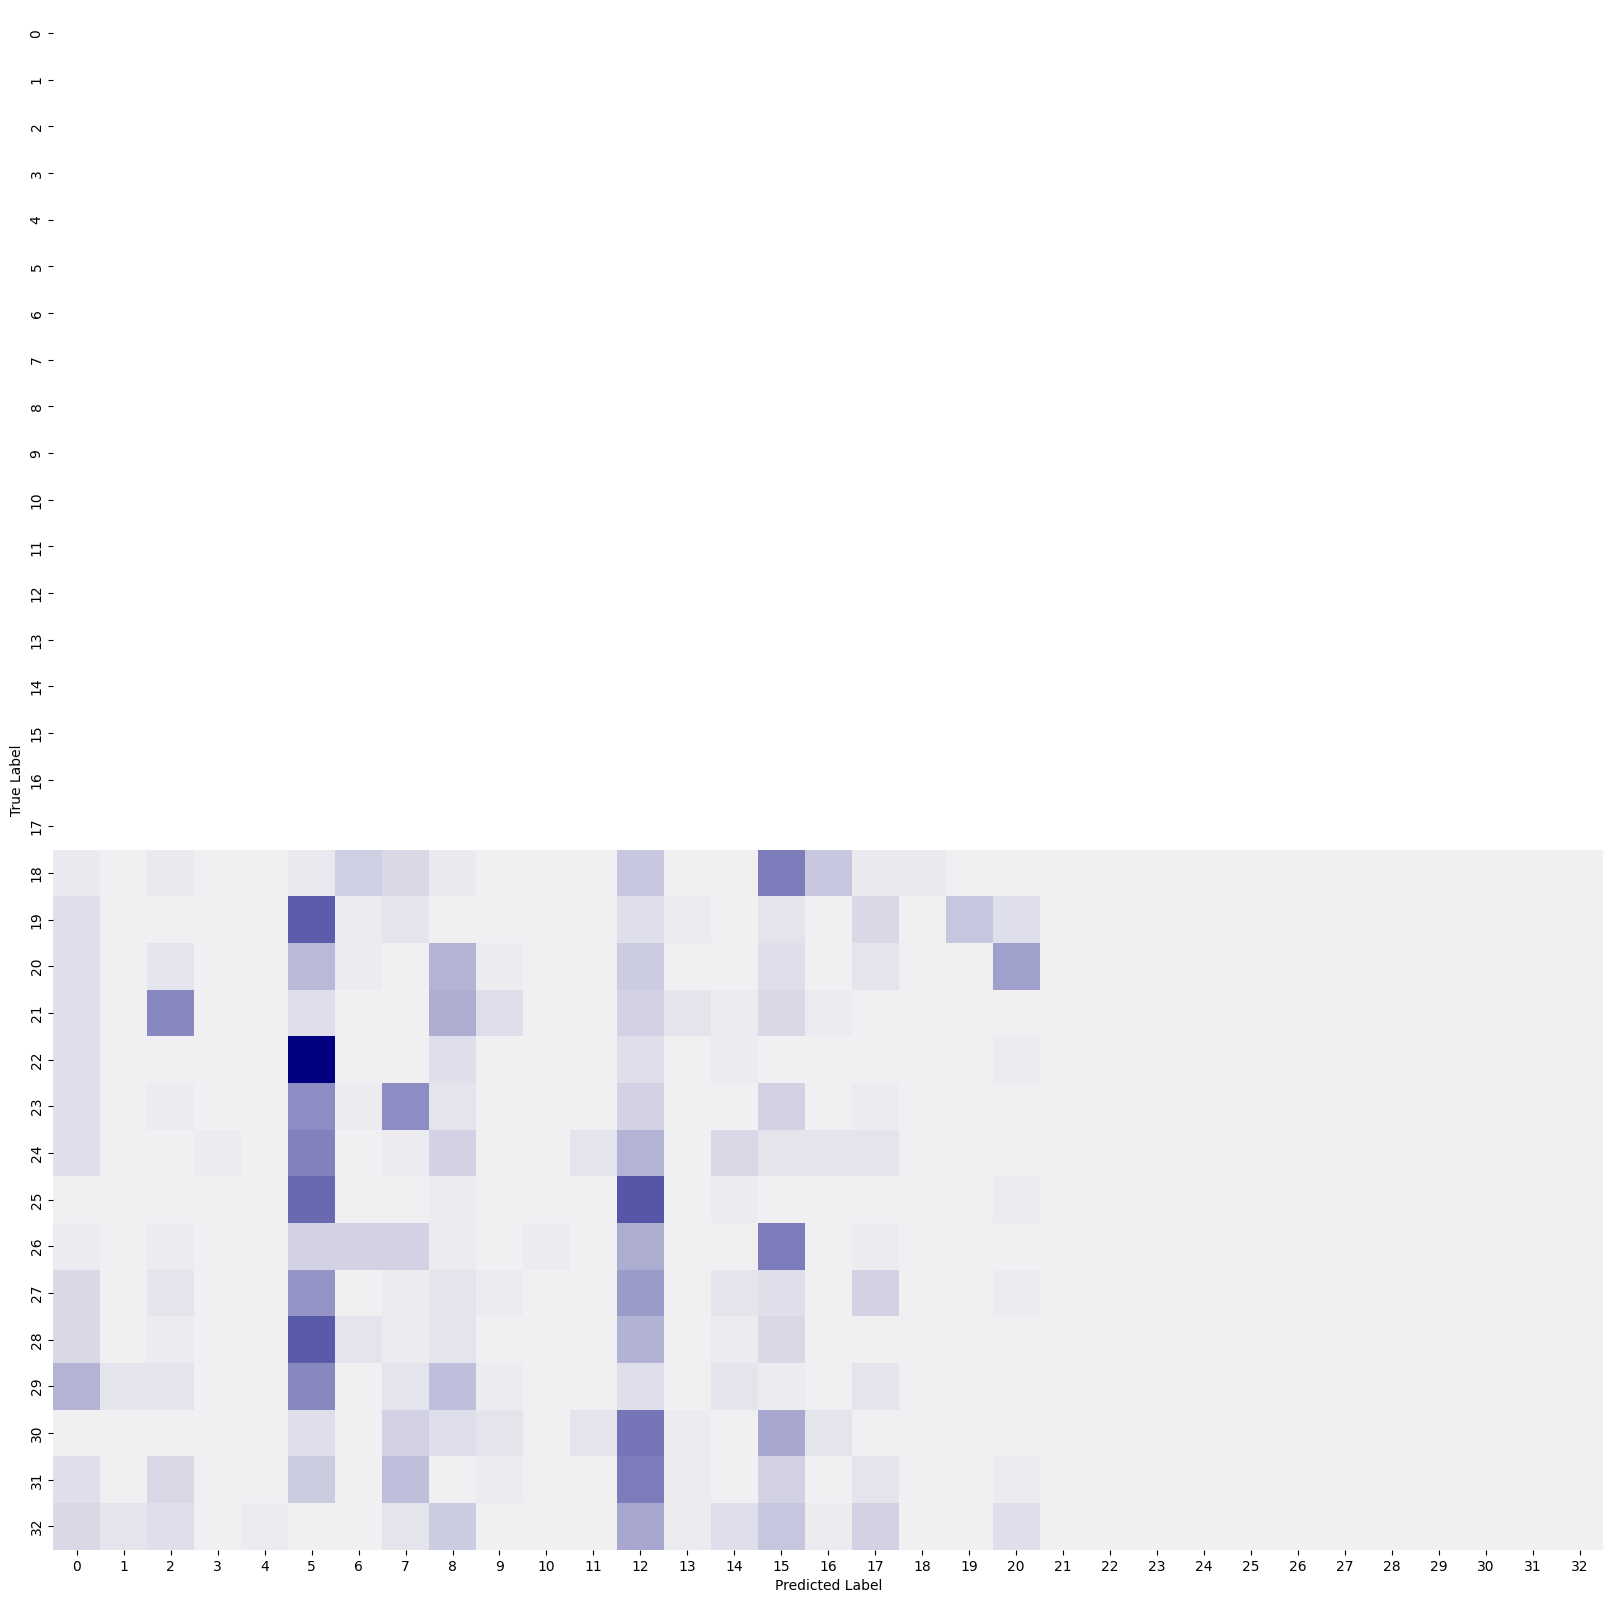

In [26]:
plot_conf(middle_label_test, pred_middle)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

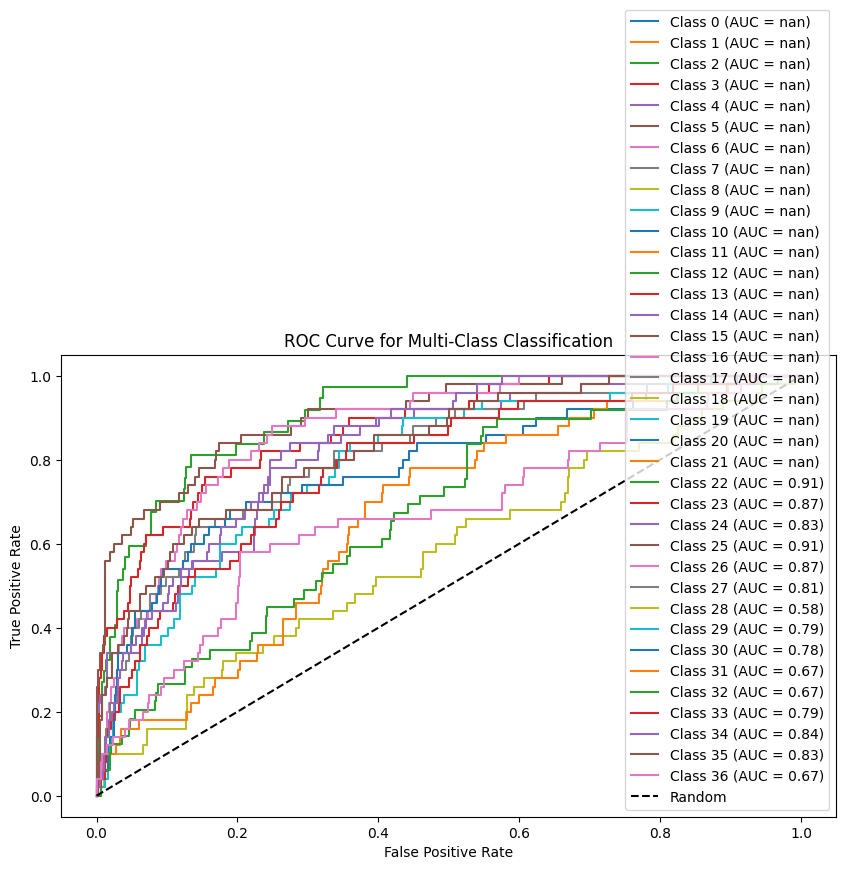

In [27]:
y_test_binarized8 = label_binarize(middle_label_test, classes=np.unique(middle_label_train))
plot_multiclass_roc_curve(new_middle_features_train, middle_label_train, new_middle_features_test, y_test_binarized8, svm_model_middle)

### First Conv Layer

In [11]:
conv1_features_train, conv1_label_train = extract_features(mobilenet_first_conv_extractor, train_loader)
conv1_features_test, conv1_label_test = extract_features(mobilenet_first_conv_extractor, test_loader)

In [12]:
new_conv1_features_train, new_conv1_features_test = pca(conv1_features_train, conv1_features_test)

In [13]:
pred_conv1, svm_model_conv1 = classify(new_conv1_features_train, new_conv1_features_test, conv1_label_train, conv1_label_test)

Accuracy: 0.0000


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10440\3818826468.py:12: RuntimeWarning: invalid value encountered in divide
  cm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


<Figure size 640x480 with 0 Axes>

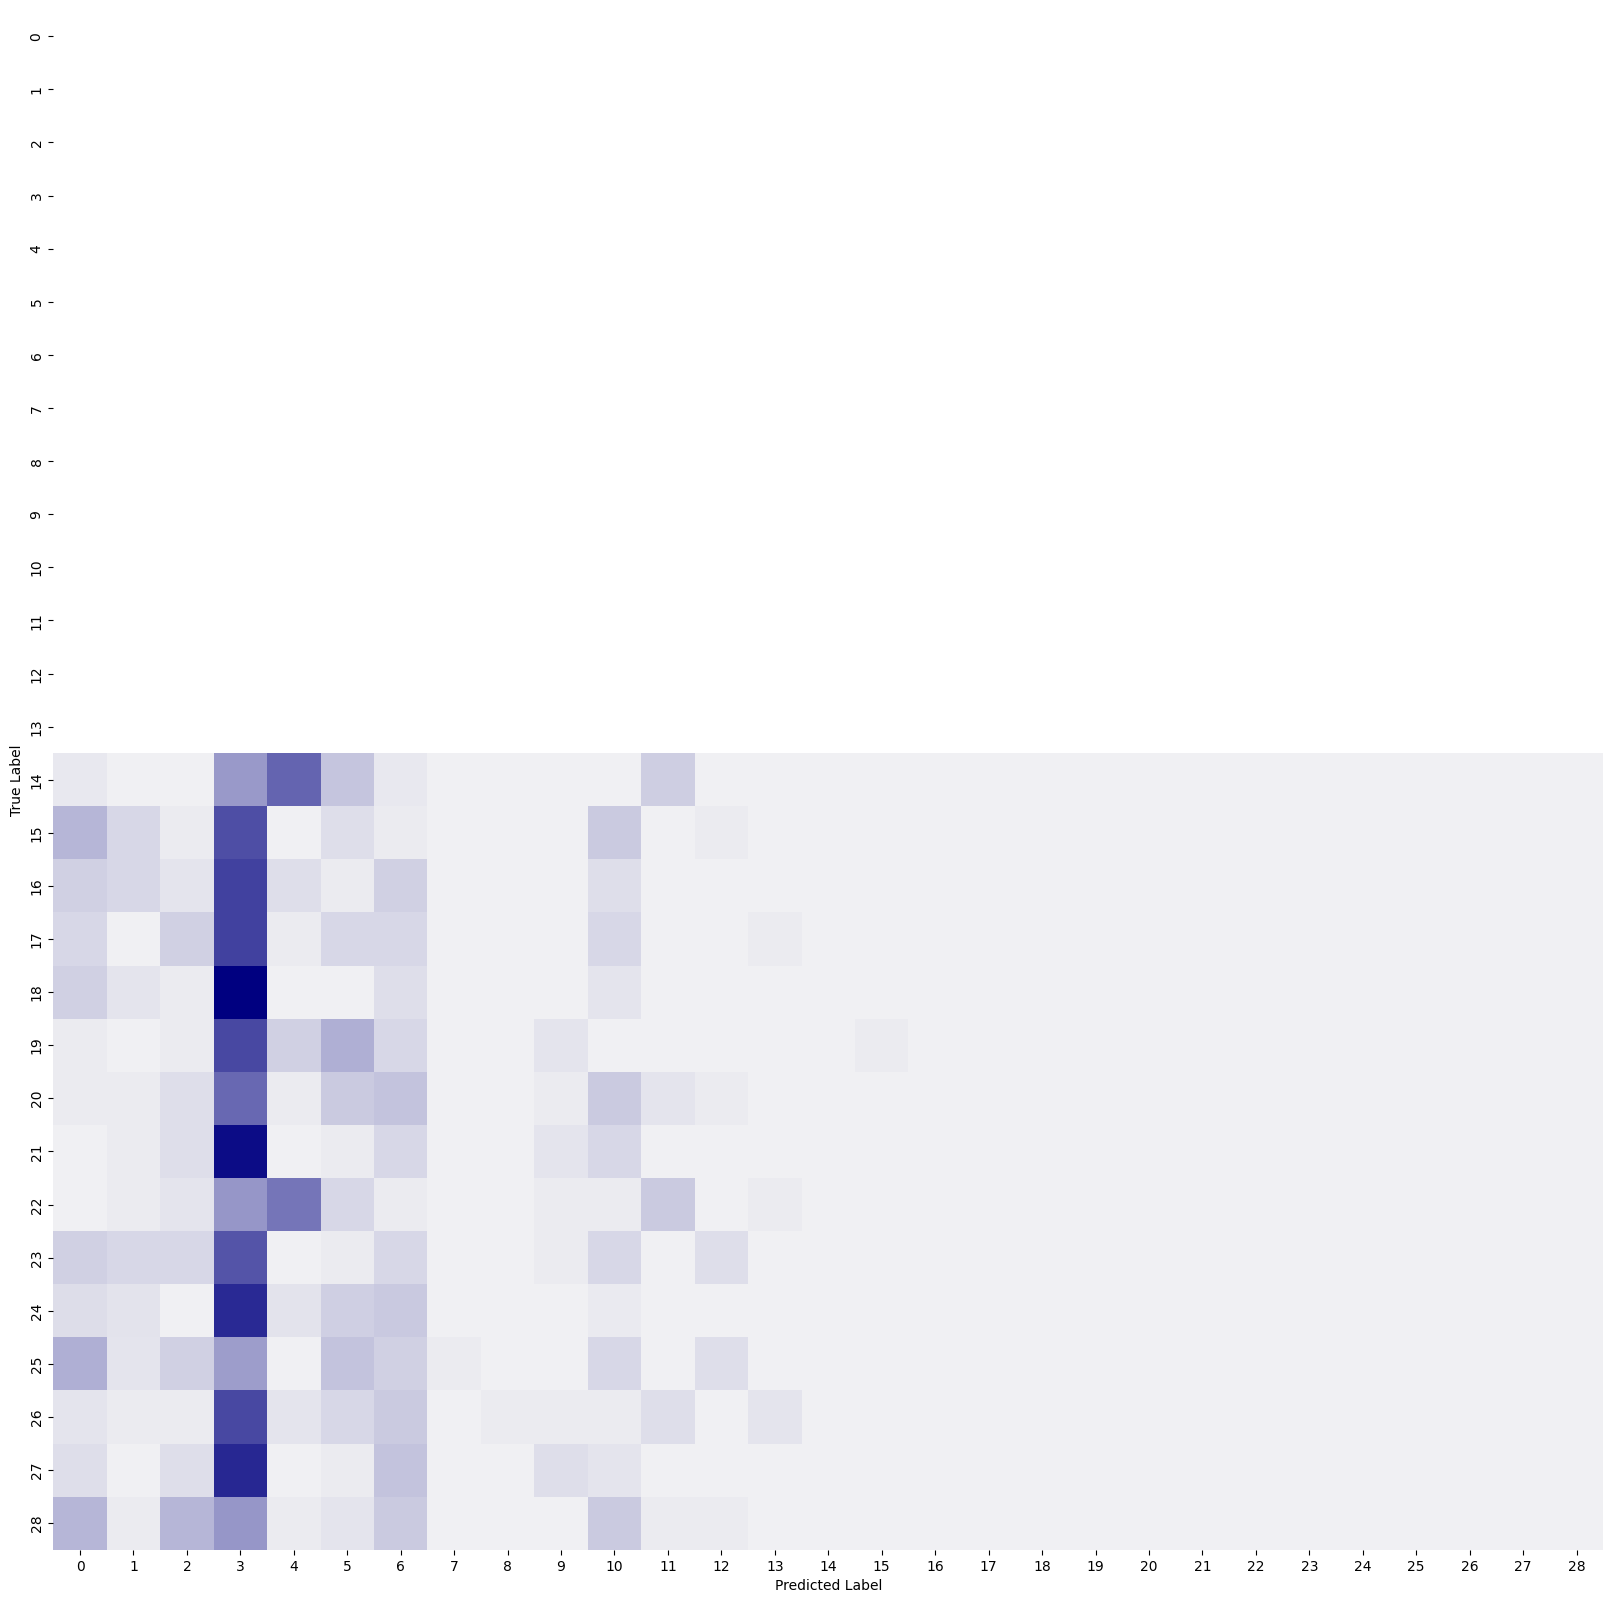

In [18]:
plot_conf(conv1_label_test, pred_conv1)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1133: Unde

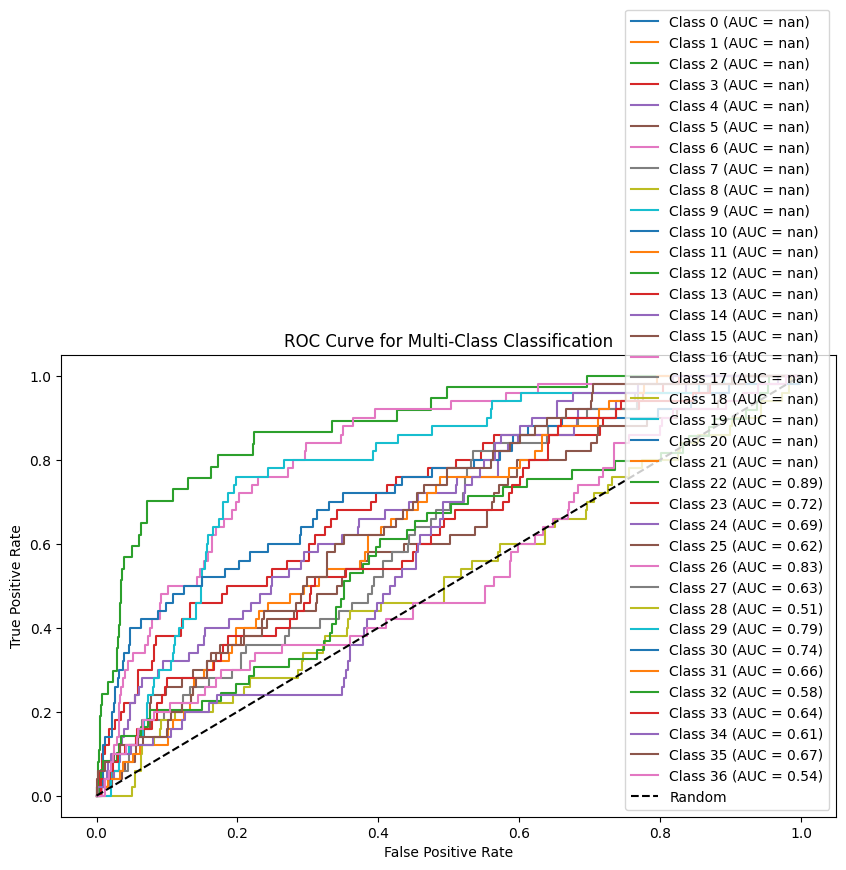

In [19]:
y_test_binarized9 = label_binarize(conv1_label_test, classes=np.unique(conv1_label_train))
plot_multiclass_roc_curve(new_conv1_features_train, conv1_label_train, new_conv1_features_test, y_test_binarized9, svm_model_conv1)

## Result

```
In the MobileNet model, the first convolution layer practically does not extract specific features because the weights are not well trained, and it may only detect some edge-lets and simple colors; hence, the accuracy is very low, and after dimension reduction with PCA, the accuracy drops to zero.
In the intermediate layer, the weights are still not well trained, so very specific structures and features are not extracted, and therefore the accuracy remains low, but because they have been trained more than the first convolution layer, their accuracy is higher. Also, because of dimension reduction with PCA again, its accuracy has decreased.
However, in the avgPool layer, because it is almost the last layer and the weights are fully trained, we have a high accuracy.
This model has a higher speed compared to the two previous models, but its accuracy is lower.


## Phase 3

In [35]:
samples = []
labels = []

# Iterate over the test_loader
for batch_samples, batch_labels in test_loader:
    samples.append(batch_samples)
    labels.append(batch_labels)

# Concatenate all samples and labels into single tensors
all_samples = torch.cat(samples, dim=0)
all_labels = torch.cat(labels, dim=0)

# Get 5 random indices
random_indices = torch.randperm(len(all_samples))[:5]

# Select 5 random samples and their corresponding labels
random_samples = all_samples[random_indices]
random_labels = all_labels[random_indices]

In [37]:
def extract_features_from_image(model, image):
    """
    Extract features from a single image using a given model.

    Args:
    - model: PyTorch model to extract features from
    - image: Input image tensor

    Returns:
    - features (numpy.ndarray): Extracted features
    """
    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation during inference
    with torch.no_grad():
        # Forward pass to get model outputs
        outputs = model(image.unsqueeze(0))  # Add an extra dimension for batch
        # Extract features
        features = outputs.squeeze().cpu().numpy()

    return features

In [185]:
def clustering(train, data_labels):
    """
    Performs K-means clustering on the given data and returns cluster centers along with the most common label for each cluster.

    Args:
    - train (numpy.ndarray): Training data for clustering
    - data_labels (numpy.ndarray): Corresponding labels for the training data

    Returns:
    - centers (numpy.ndarray): Coordinates of the cluster centers
    - most_common_labels (dict): Dictionary mapping each cluster to its most common label
    """
    # Perform K-means clustering
    kmeans = KMeans(37, n_init=20, random_state=42)
    labels = kmeans.fit_predict(train)
    centers = kmeans.cluster_centers_
    
    # Find the most common label for each cluster
    most_common_labels = {}
    for cluster in range(len(centers)):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_data_labels = data_labels[cluster_indices]
        most_common_label = np.argmax(np.bincount(cluster_data_labels))
        most_common_labels[cluster] = most_common_label
    
    # Visualize the clustering results
    plt.scatter(train[:, 0], train[:, 1], c=labels, cmap='viridis', alpha=0.5)  # Scatter plot of the data points colored by cluster
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X')  # Plotting cluster centers
    plt.title('Cluster Centers')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
    return centers, most_common_labels


In [186]:
def compare_with_cluster(image_features, cluster_centers):
    """
    Compares the given image features with cluster centers using cosine distance and returns the index of the closest cluster.

    Args:
    - image_features (numpy.ndarray): Features of the input image
    - cluster_centers (numpy.ndarray): Coordinates of the cluster centers

    Returns:
    - closest_cluster_idx (int): Index of the closest cluster center to the image features
    """
    # Calculate cosine distances between the image features and cluster centers
    distances = np.array([cosine(image_features, center) for center in cluster_centers])
    # Find the index of the closest cluster center
    closest_cluster_idx = np.argmin(distances)
    
    return closest_cluster_idx


In [50]:
def plot_image_from_tensor(image_tensor):
    # Convert the image tensor to a NumPy array
    image_array = image_tensor.permute(1, 2, 0).numpy()  # Convert from CHW to HWC format
    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

## ResNet

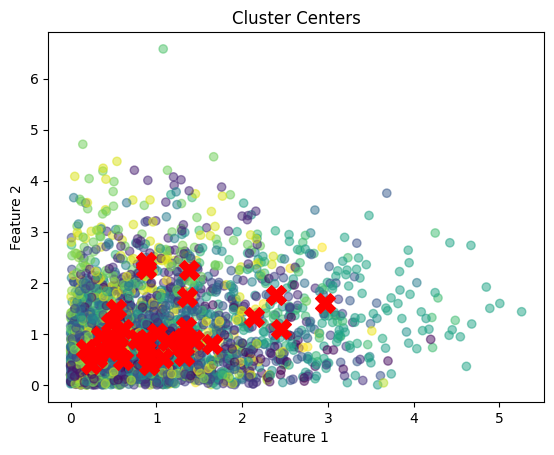

In [108]:
resnet_centers, most_label = clustering(avg_features_train, avg_label_train)

#### example 2

In [142]:
test_resnet_features = extract_features_from_image(resnet18_avgpool_extractor, random_samples[3])

closest_cluster_idx = compare_with_cluster(test_resnet_features, resnet_centers)
closest_cluster_idx

8

In [139]:
most_label[8]

6

#### predicted label

In [136]:
test_loader.dataset.classes[most_label[closest_cluster_idx]]

'Birman'

#### true label

In [135]:
test_loader.dataset.classes[random_labels[3]]

'Ragdoll'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


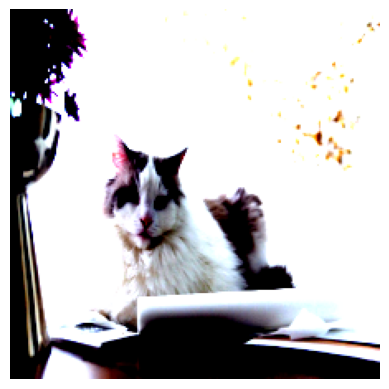

In [51]:
plot_image_from_tensor(random_samples[3])

``` as you can see, the predicted label and true label are both cats that are very similar and they probably goes to one cluster```

##### example 2

In [145]:
test_resnet_features1 = extract_features_from_image(resnet18_avgpool_extractor, random_samples[1])

closest_cluster_idx2 = compare_with_cluster(test_resnet_features1, resnet_centers)
closest_cluster_idx2

26

In [146]:
most_label[26]

27

#### predicted label

In [147]:
test_loader.dataset.classes[27]

'Russian Blue'

#### true label

In [155]:
test_loader.dataset.classes[random_labels[1]]

'Russian Blue'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


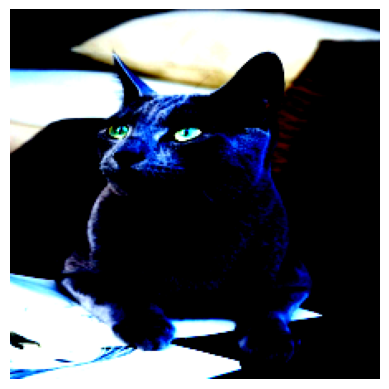

In [149]:
plot_image_from_tensor(random_samples[1])

``` as you can see, it predicts it right and the extracted features was really close to the 26th cluster that most```

## GoogleNet

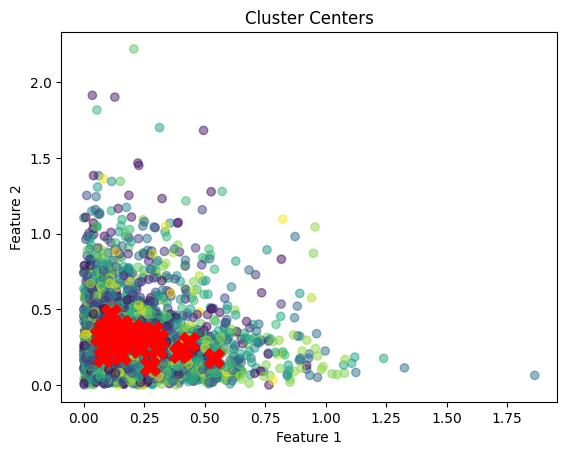

In [152]:
googleNet_centers, most_label_gn = clustering(gn_avg_features_train, gn_avg_label_train)

### example 1

In [153]:
test_googleNet_features = extract_features_from_image(googleNet_avgpool_extractor, random_samples[0])

closest_cluster_idx3 = compare_with_cluster(test_googleNet_features, googleNet_centers)
closest_cluster_idx3

7

In [154]:
most_label_gn[7]

22

#### predicted label

In [156]:
test_loader.dataset.classes[22]

'Newfoundland'

#### true label

In [157]:
test_loader.dataset.classes[random_labels[0]]

'Newfoundland'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


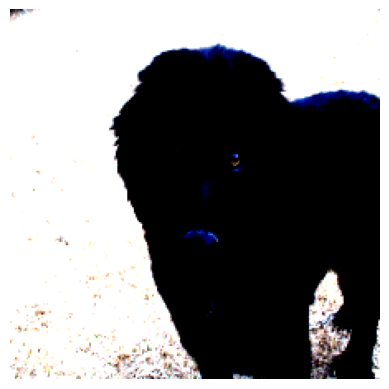

In [158]:
plot_image_from_tensor(random_samples[0])

``` as you can see, it predicts true. the features of this image was so close to the features the Newfoundland class```

#### example 2

In [159]:
test_googleNet_features1 = extract_features_from_image(googleNet_avgpool_extractor, random_samples[2])

closest_cluster_idx4= compare_with_cluster(test_googleNet_features1, googleNet_centers)
closest_cluster_idx4

28

In [160]:
most_label_gn[28]

24

#### predicted label

In [161]:
test_loader.dataset.classes[24]

'Pomeranian'

#### true label

In [163]:
test_loader.dataset.classes[random_labels[2]]

'Pomeranian'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


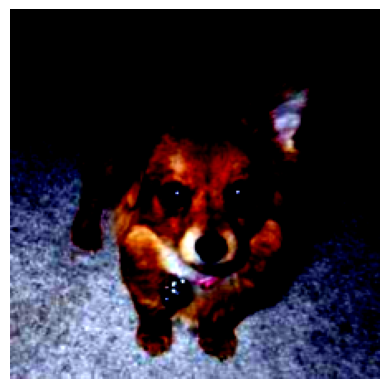

In [164]:
plot_image_from_tensor(random_samples[2])

``` as you can see, it predicts true. the features of this image was so close to the features the Pomeranian class```

## MobileNet

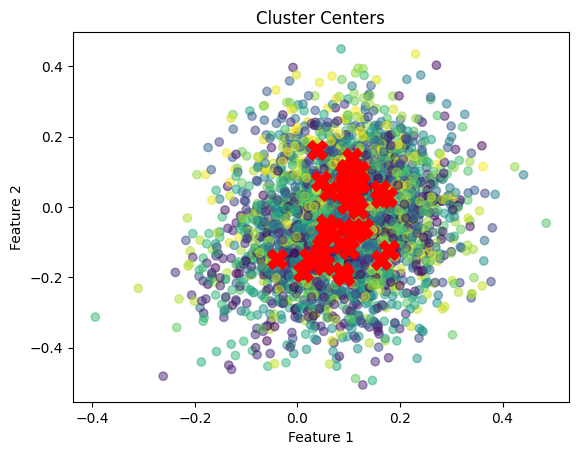

In [175]:
mobileNet_centers, most_label_mn = clustering(mn_avg_features_train, mn_avg_label_train)

#### example 1

In [176]:
test_mobileNet_features = extract_features_from_image(mobilenet_avgpool_extractor, random_samples[4])

closest_cluster_idx5 = compare_with_cluster(test_mobileNet_features, mobileNet_centers)
closest_cluster_idx5

11

In [177]:
most_label_mn[11]

15

#### predicted label

In [178]:
test_loader.dataset.classes[15]

'Great Pyrenees'

#### true label

In [179]:
test_loader.dataset.classes[random_labels[4]]

'Wheaten Terrier'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


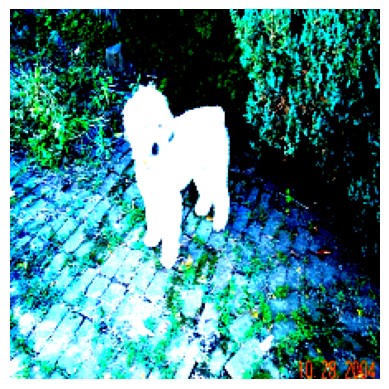

In [171]:
plot_image_from_tensor(random_samples[4])

``` in this sample, it doesn't predict the label very close to true label. but this image is not so clear and it may assigned to Wheaten Terrier because you can't see anything from the dog but the shape and color of these two classes are similar.```

#### example 2

In [172]:
test_mobileNet_features1 = extract_features_from_image(mobilenet_avgpool_extractor, random_samples[1])

closest_cluster_idx6 = compare_with_cluster(test_mobileNet_features1, mobileNet_centers)
closest_cluster_idx6

32

In [180]:
most_label_mn[32]

9

#### predicted label

In [181]:
test_loader.dataset.classes[9]

'British Shorthair'

#### true label

In [183]:
test_loader.dataset.classes[random_labels[1]]

'Russian Blue'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


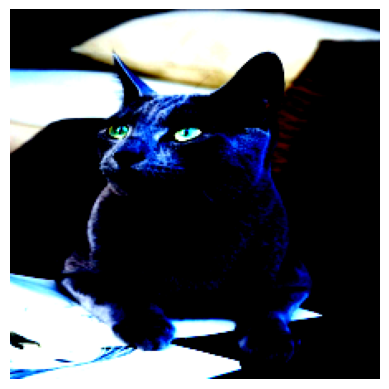

In [184]:
plot_image_from_tensor(random_samples[1])

``` these two type of cats are similar a little and so they may goes to one cluster. In general the accuracy of mobileNet is not too good but it is famous for its speed.```